# Evaluating U-Net and simple single convoluation baseline models

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
%reload_ext autoreload
import os
import sys

import numpy as np
import xarray as xr
import yaml

from ml_downscaling_emulator.evaluation import load_model, predict, open_test_set, compare_preds, plot_mean_diffs
from ml_downscaling_emulator.helpers import plots_at_ts
# dir2 = os.path.abspath('../../src/ml_downscaling_emulator/unet/unet')
# dir1 = os.path.dirname(dir2)
# if not dir1 in sys.path: sys.path.append(dir1)
# import unet
from ml_downscaling_emulator.unet import unet as unet
# weird hack as I moved the unet package foolishly
sys.modules['unet'] = unet

scale_factors = [2, 4, 8, 16, 27]

In [3]:
test_sets = {sf: open_test_set(f"../../../../derived_data/nc-datasets/2.2km-coarsened-{sf}x_london_pr/test.nc") for sf in scale_factors}

In [4]:
data = {"u-net": {}, "simple-conv": {}, "lo-res": {}}

for arch in ["simple-conv", "u-net", "lo-res"]:
    for sf in scale_factors:
        dataset = f"2.2km-coarsened-{sf}x_london_pr"
        pred_path = os.path.join(os.environ["DERIVED_DATA"], "evaluation", dataset, arch, "test", "predictions.nc")
        bias_path = os.path.join(os.environ["DERIVED_DATA"], "evaluation", dataset, arch, "test", "mean-diff.nc")
        data[arch][sf] = {"predictions": xr.open_dataset(pred_path), "bias": xr.open_dataset(bias_path)}


## 2x coarsened

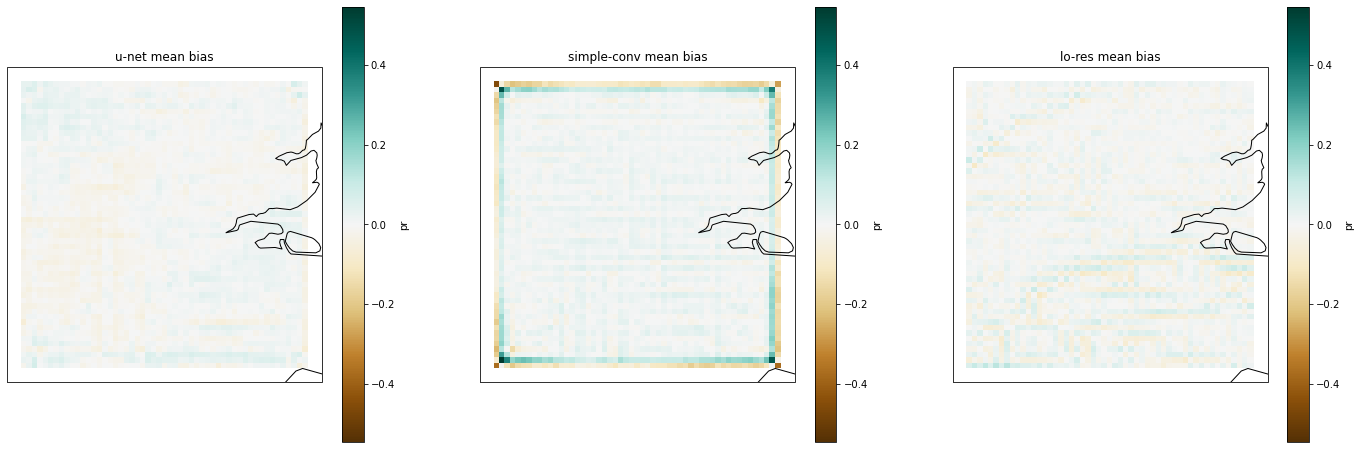

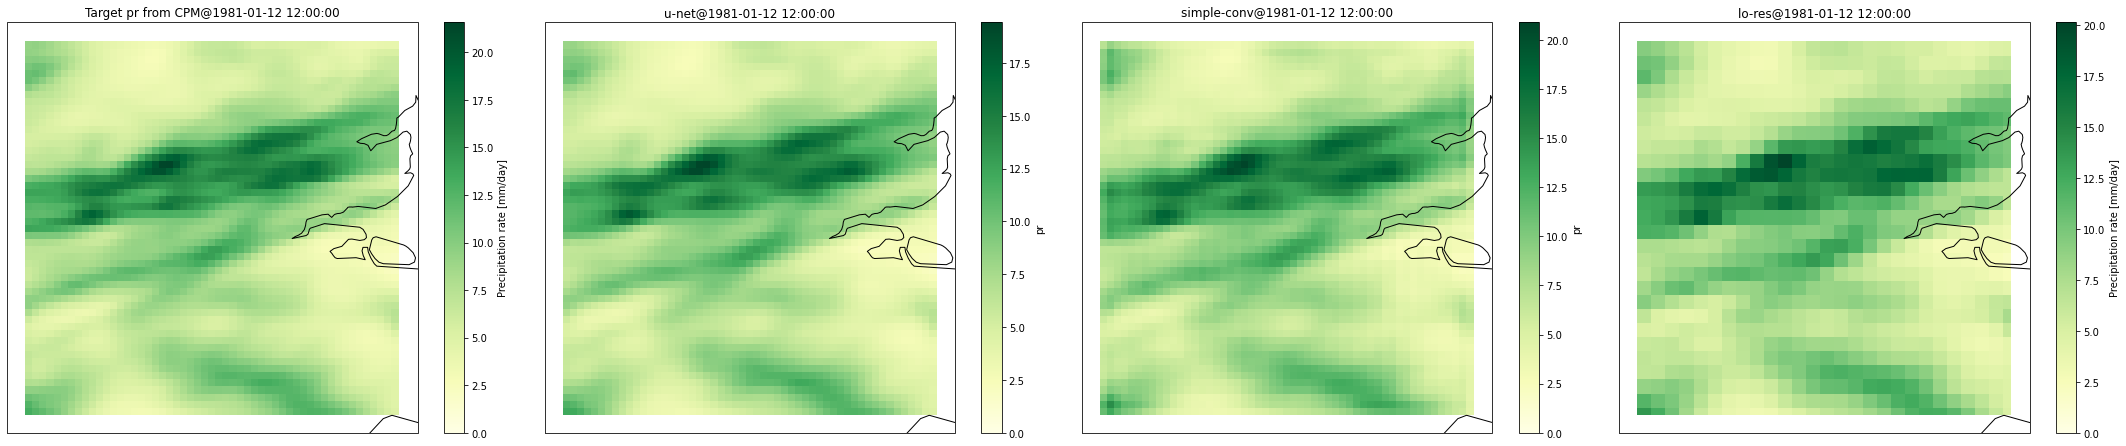

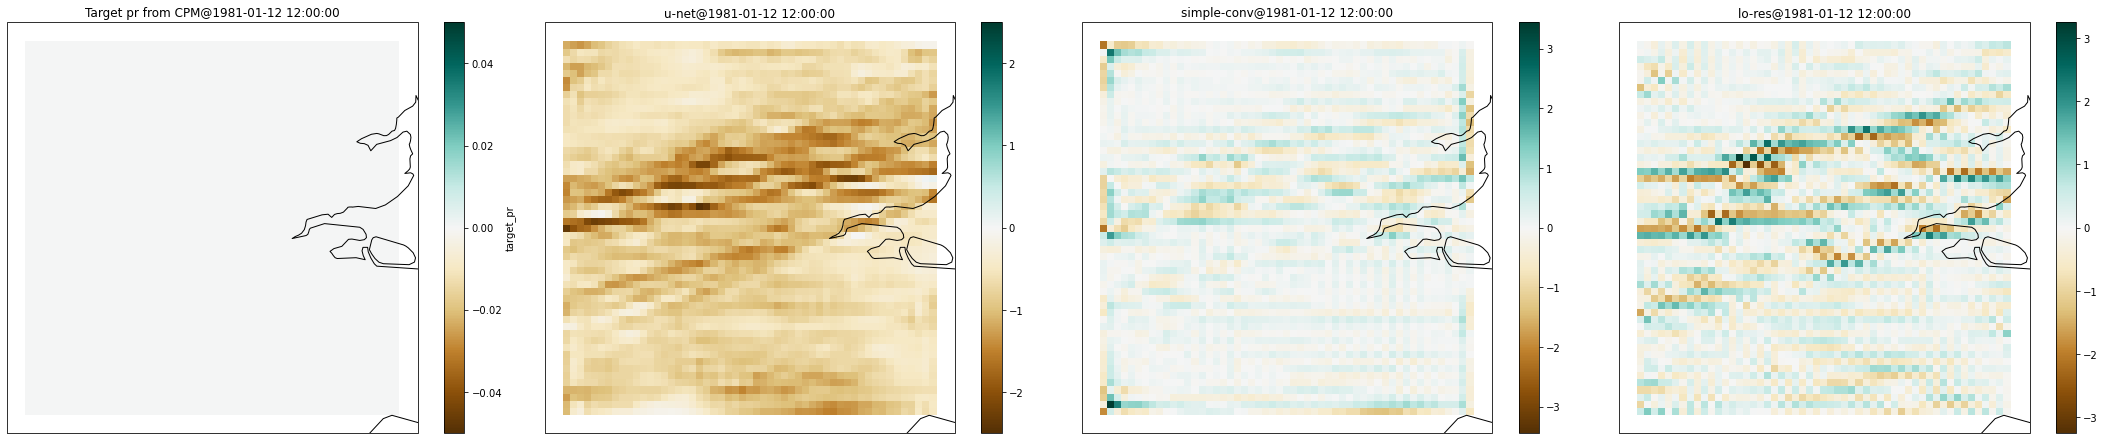

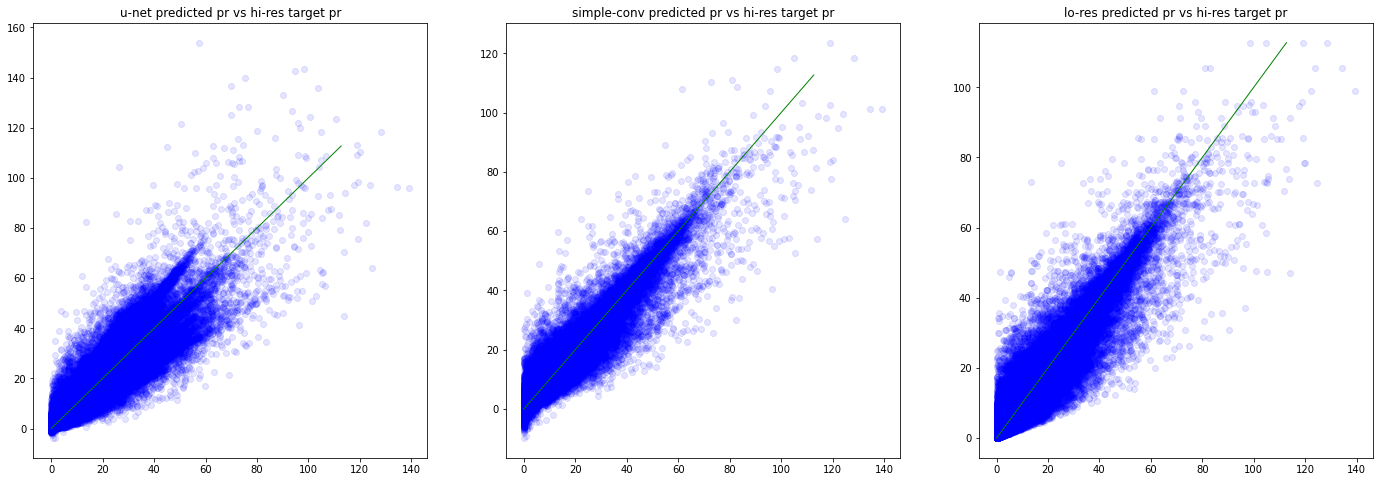

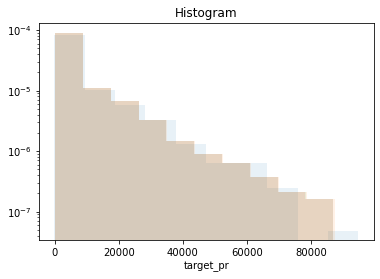

In [18]:
sf = 2
compare_preds([data[arch][sf]["predictions"] for arch in data.keys()], [data[arch][sf]["bias"] for arch in data.keys()], test_sets[sf], list(data.keys()))

## 4x coarsened

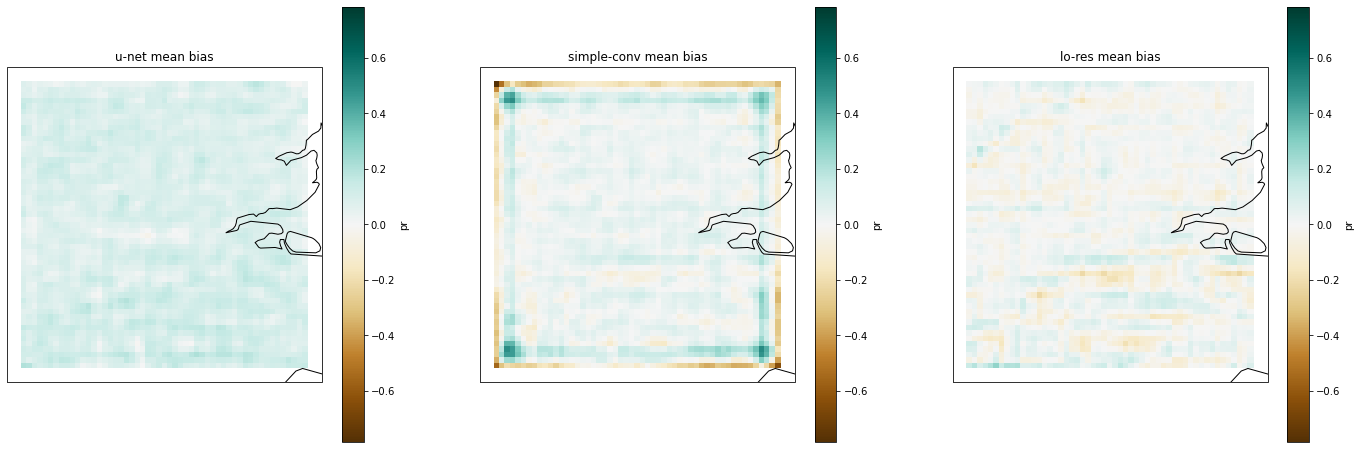

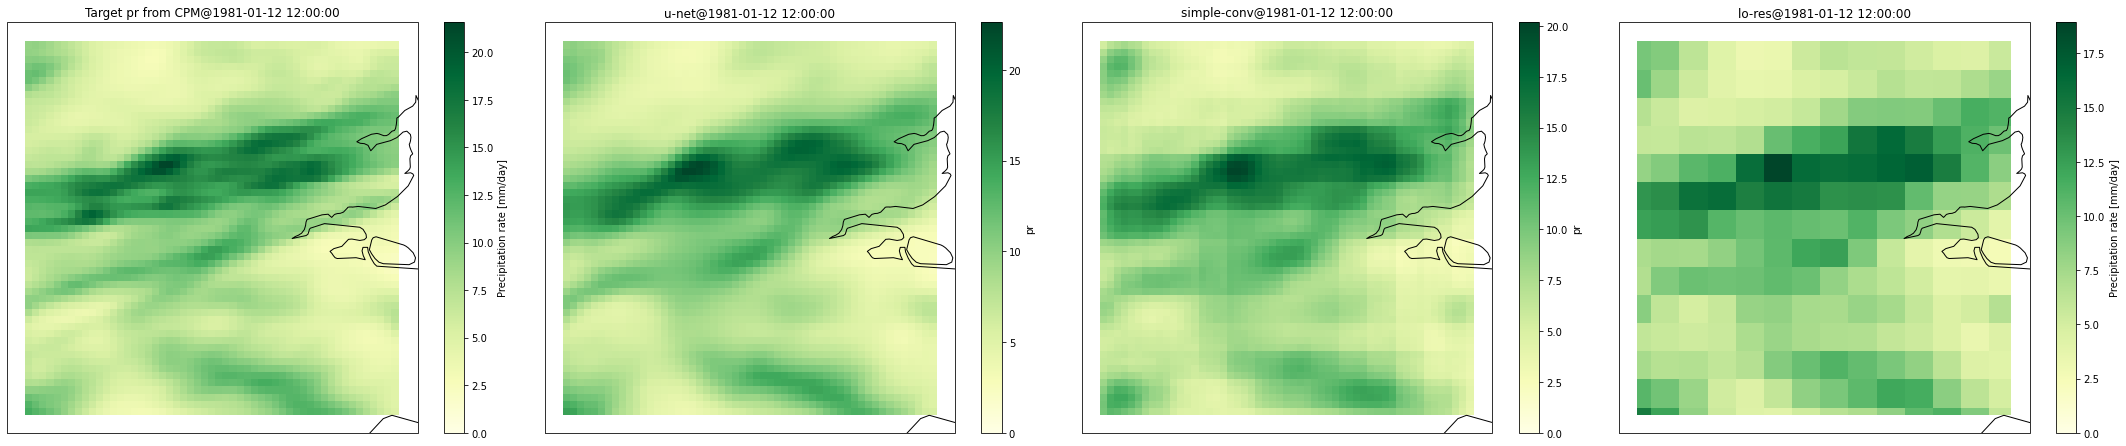

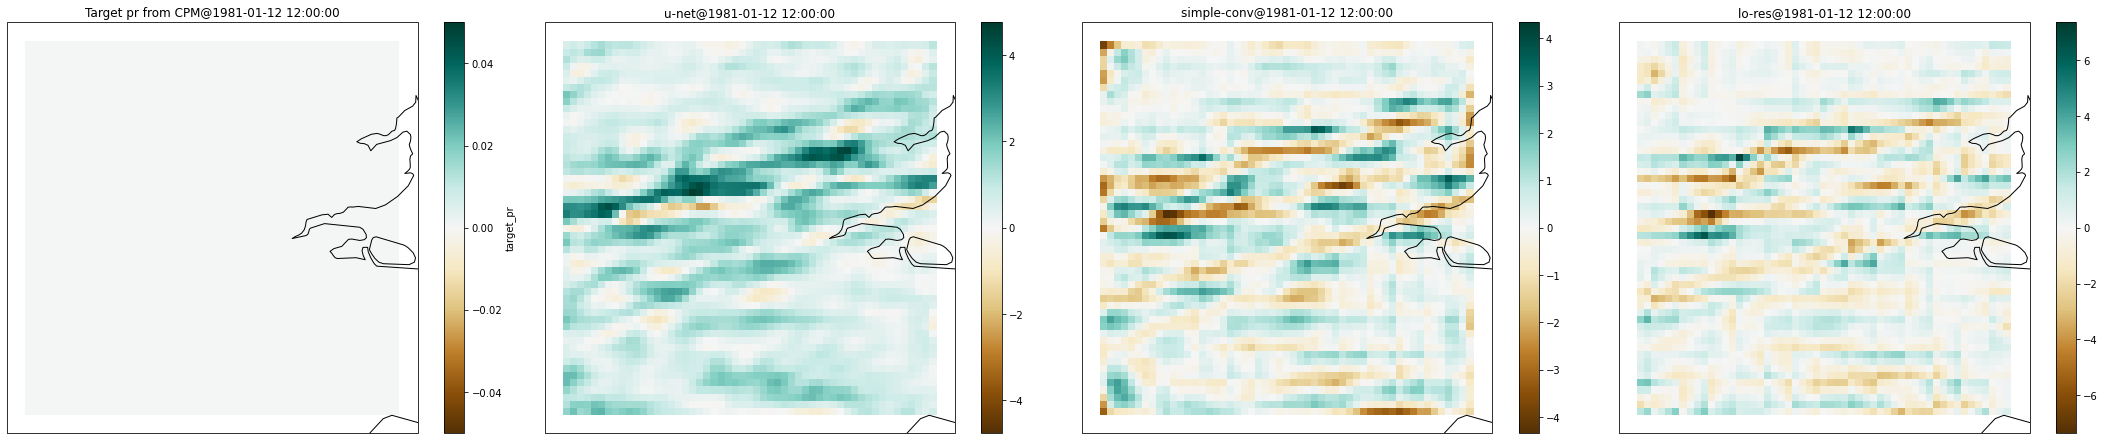

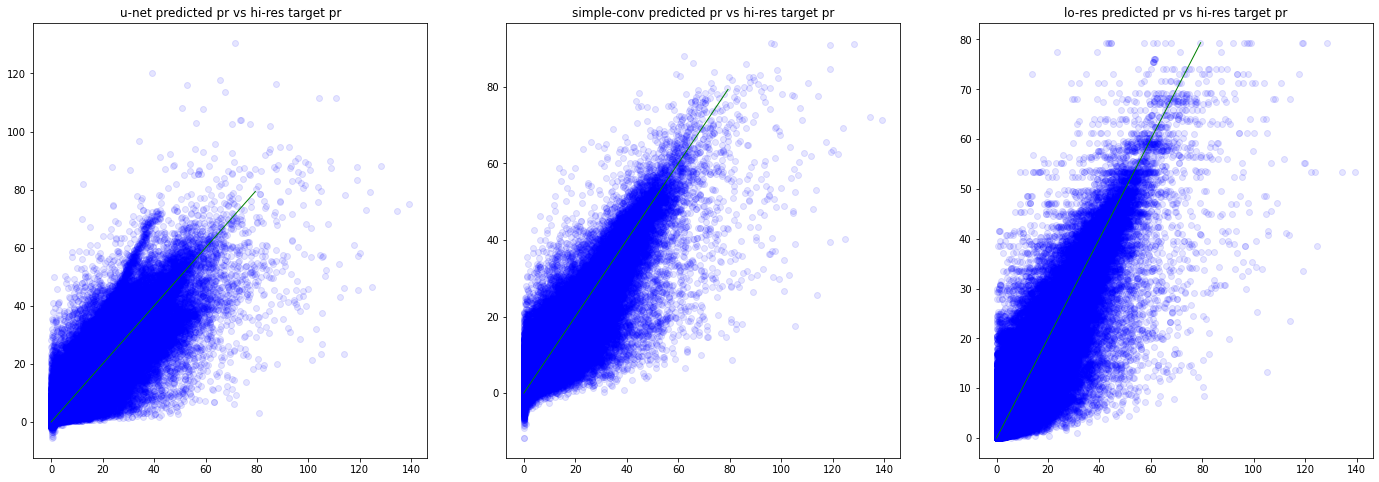

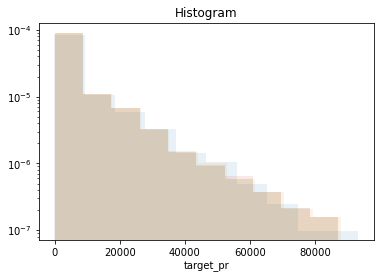

In [19]:
sf = 4
compare_preds([data[arch][sf]["predictions"] for arch in data.keys()], [data[arch][sf]["bias"] for arch in data.keys()], test_sets[sf], list(data.keys()))

## 8x coarsened

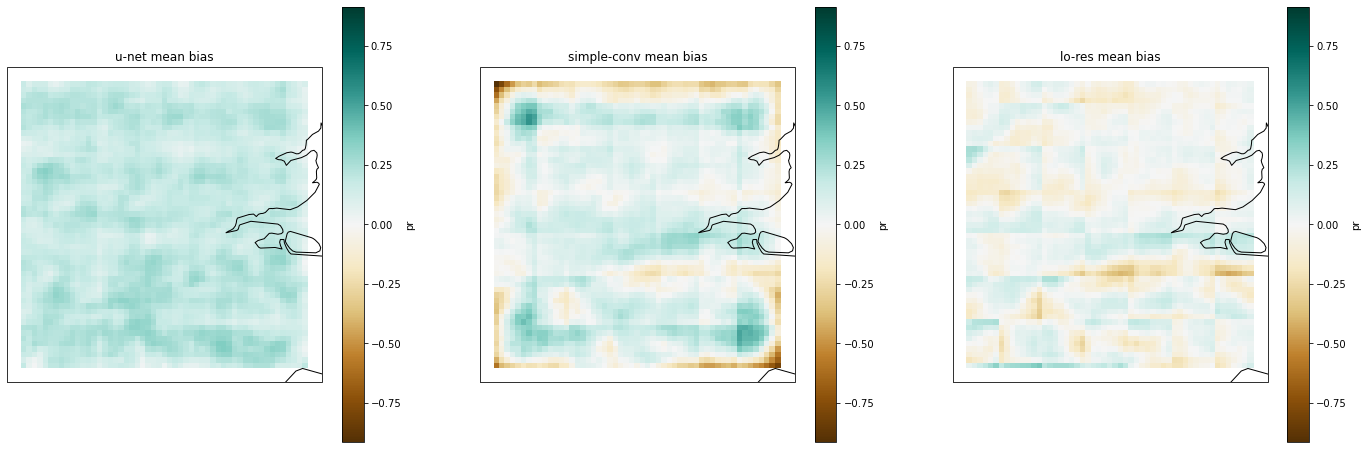

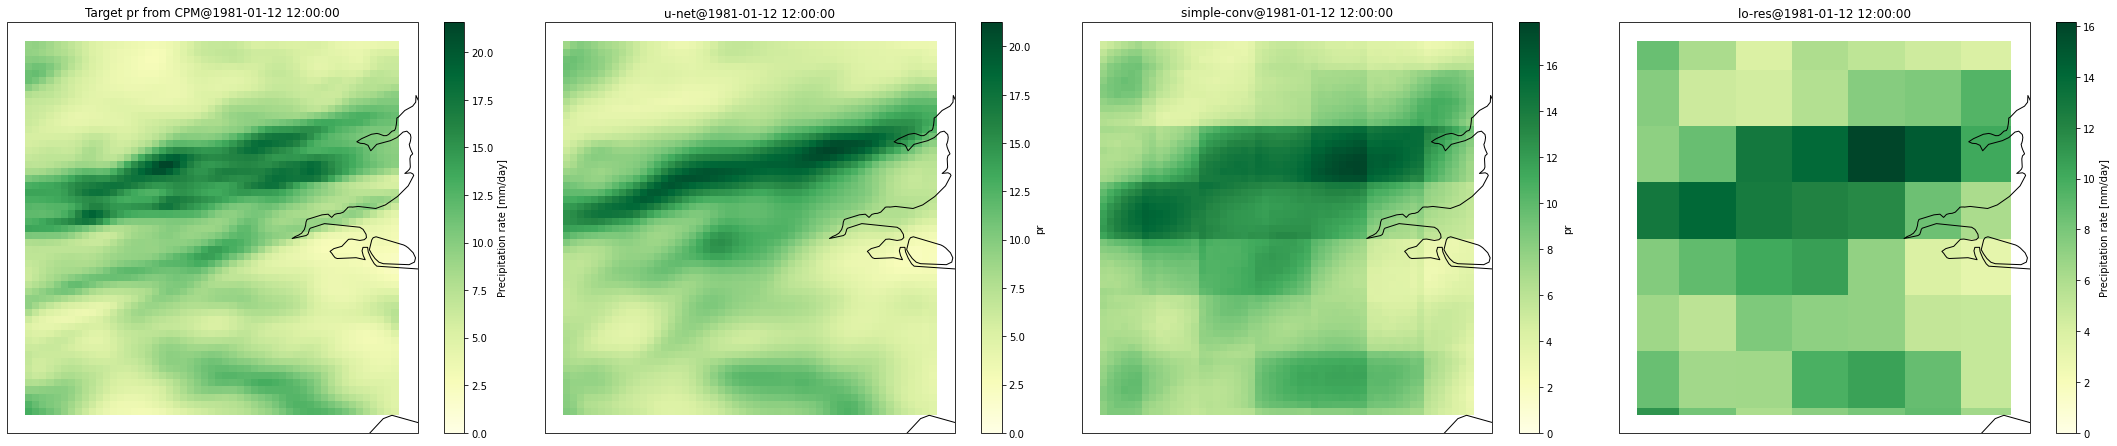

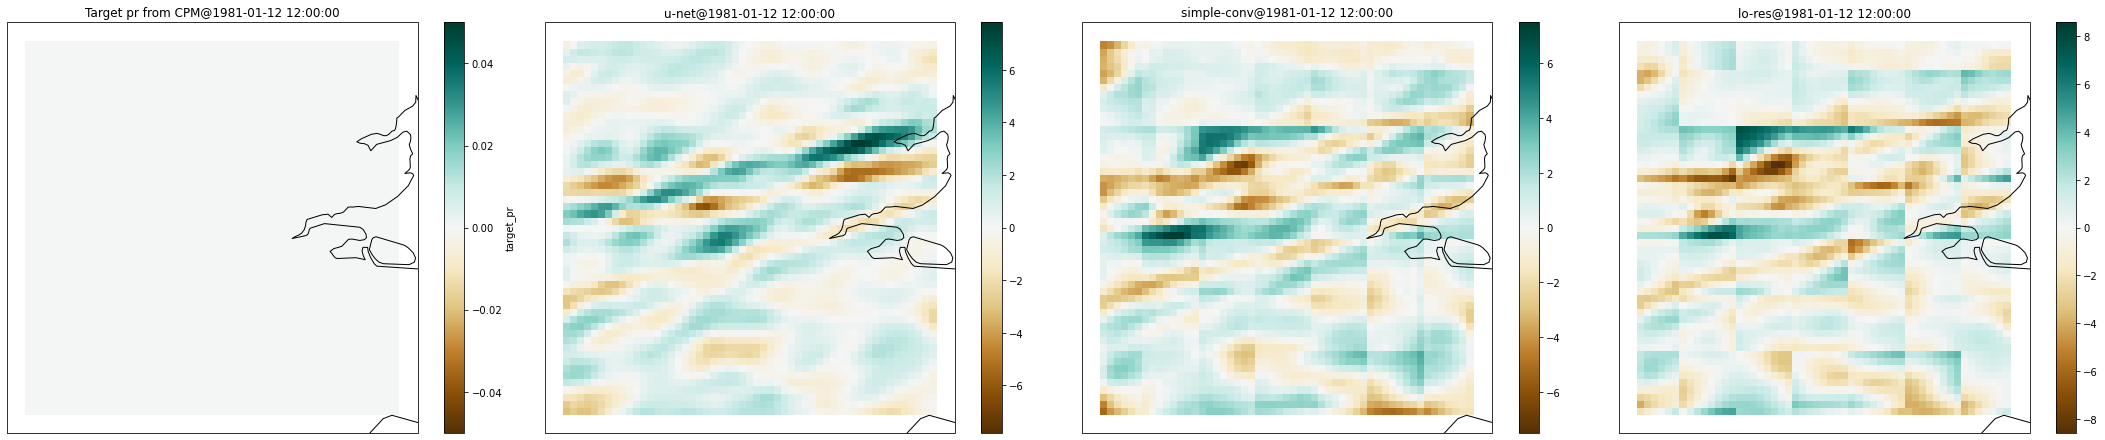

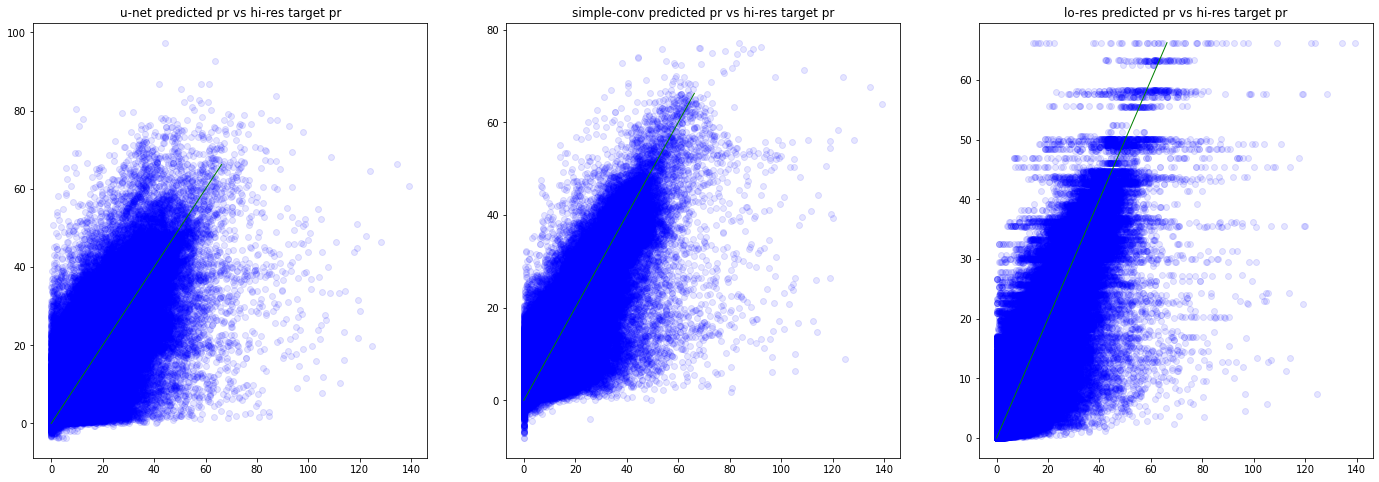

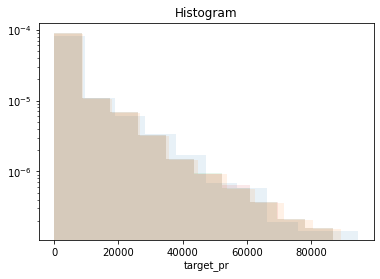

In [20]:
sf = 8
compare_preds([data[arch][sf]["predictions"] for arch in data.keys()], [data[arch][sf]["bias"] for arch in data.keys()], test_sets[sf], list(data.keys()))

## 16x coarsened

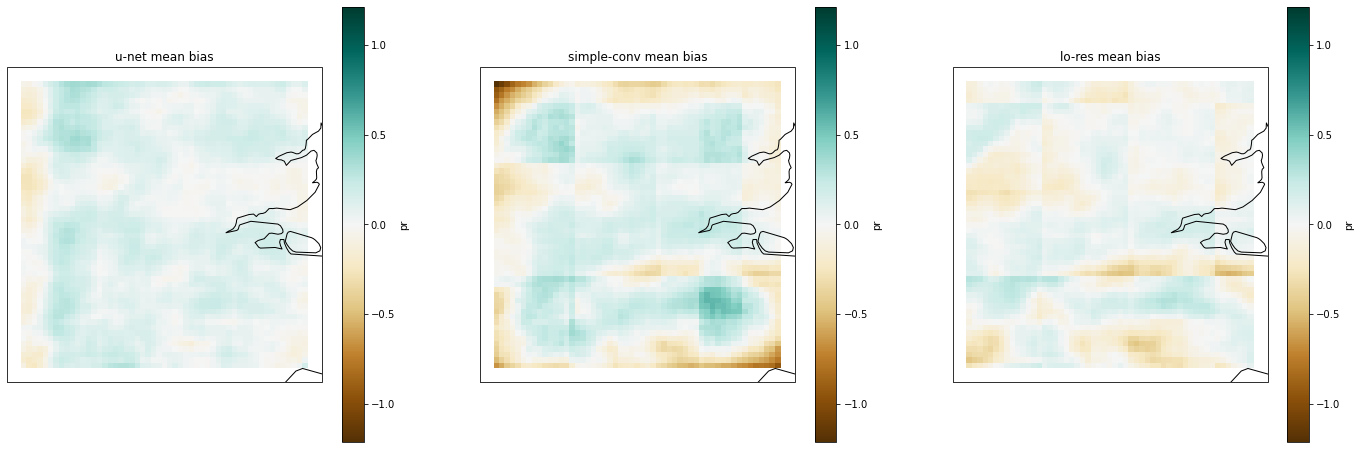

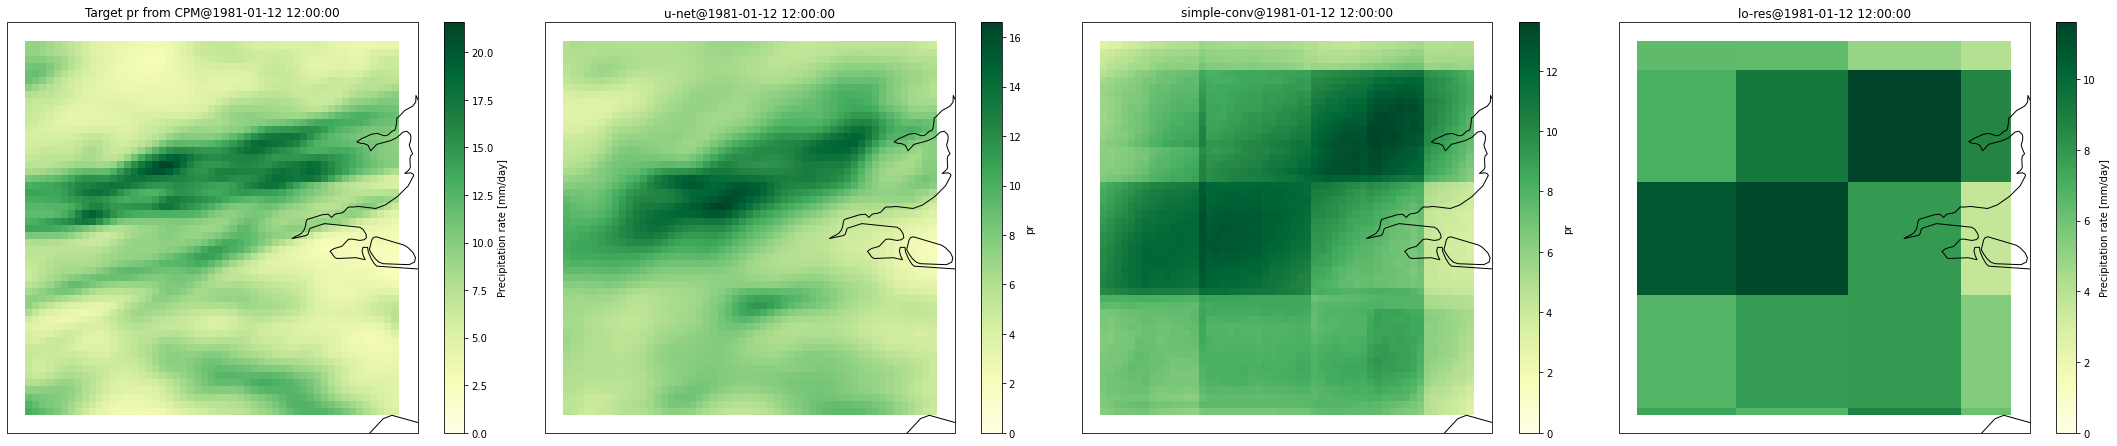

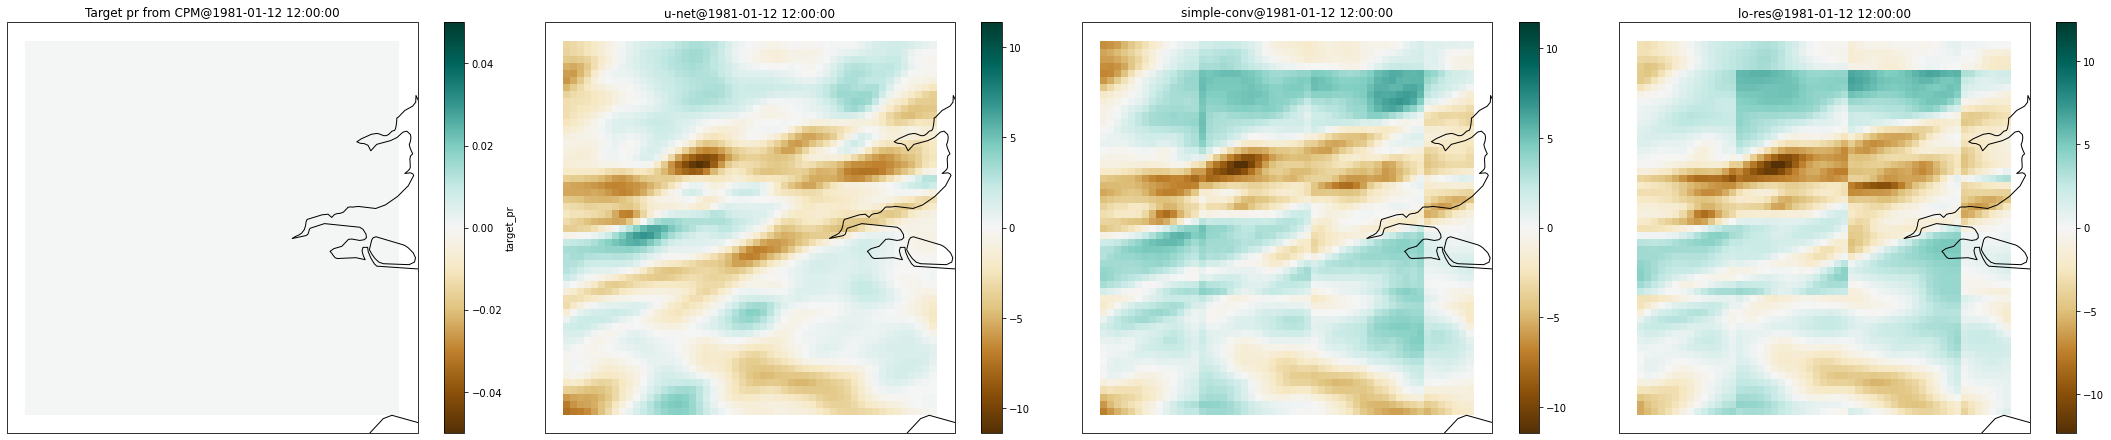

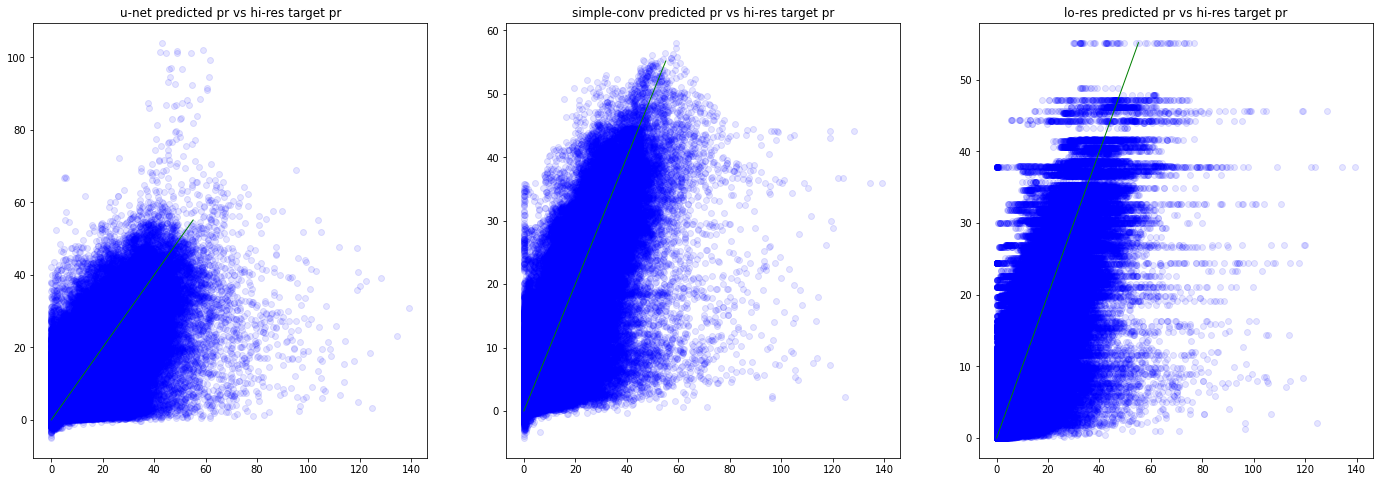

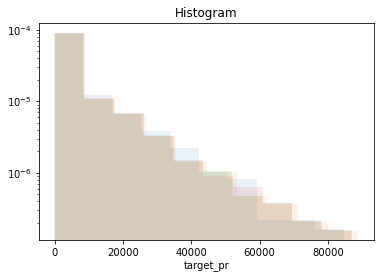

In [21]:
sf = 16
compare_preds([data[arch][sf]["predictions"] for arch in data.keys()], [data[arch][sf]["bias"] for arch in data.keys()], test_sets[sf], list(data.keys()))

## 27x coarsened (~GCM resolution)

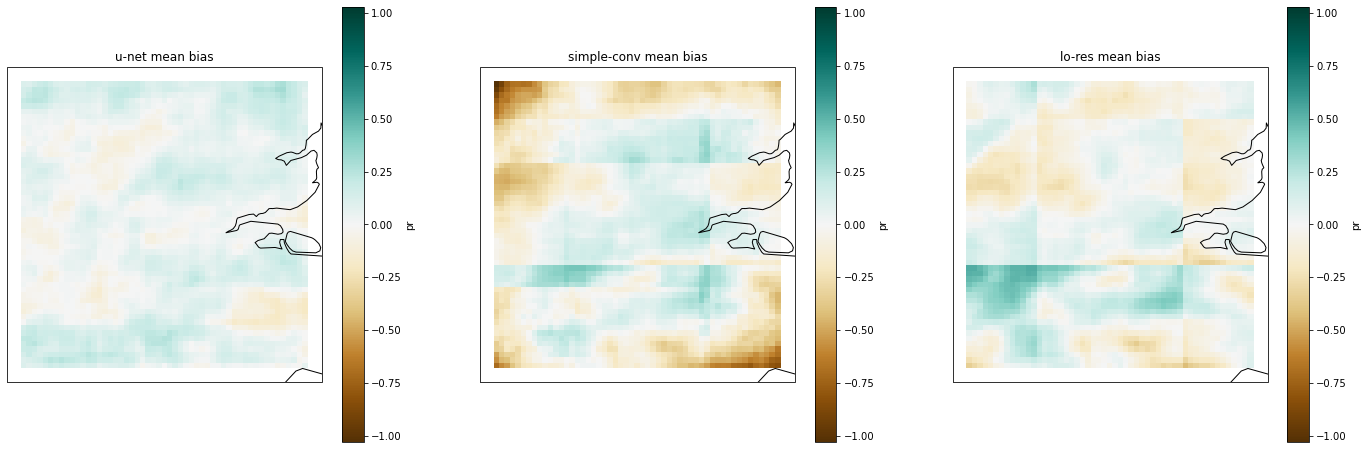

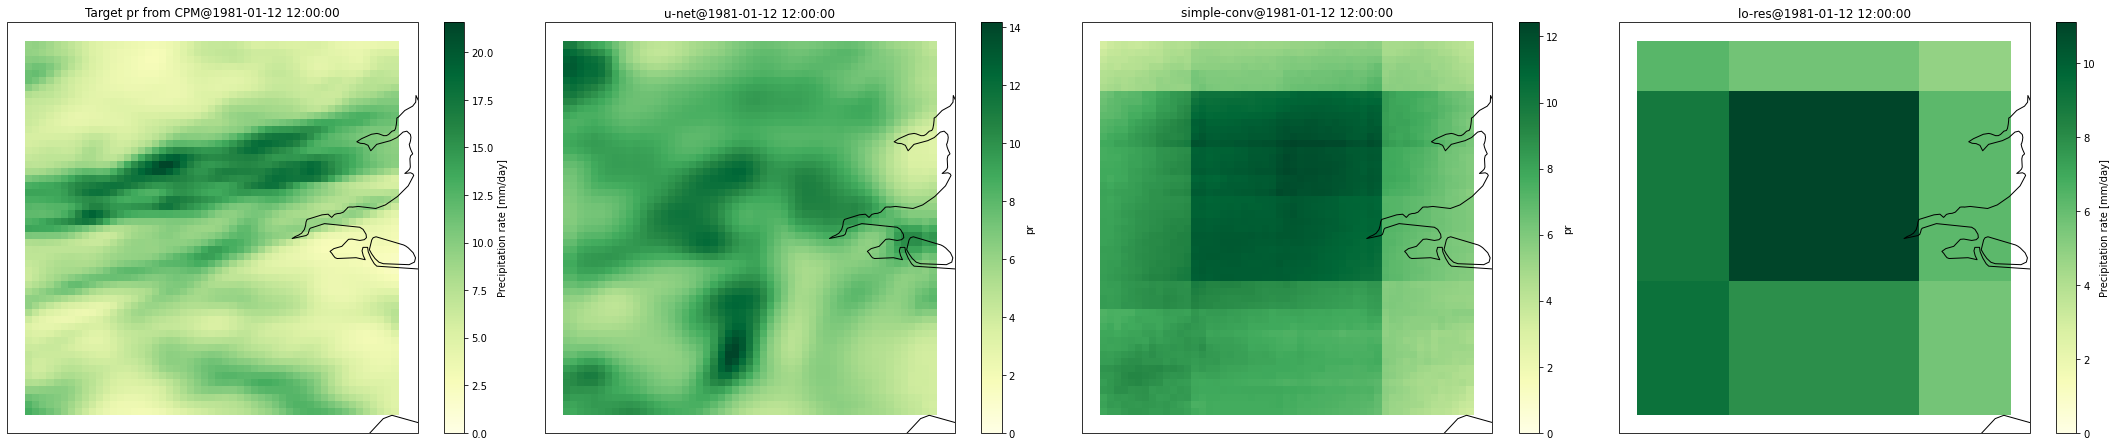

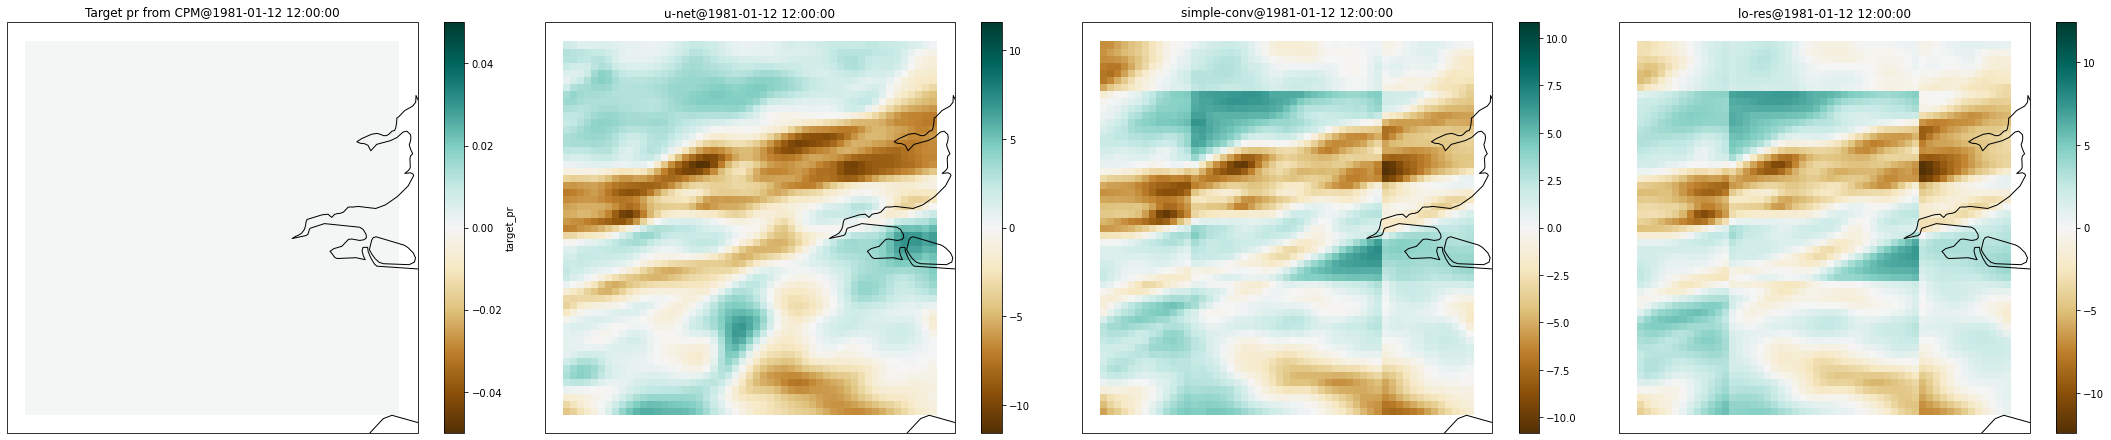

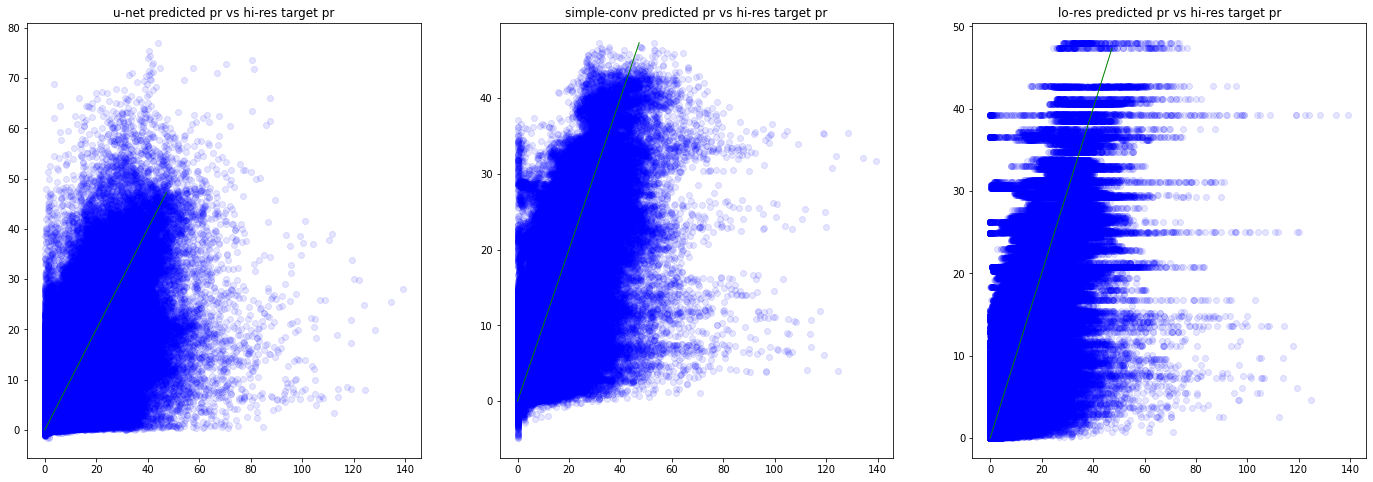

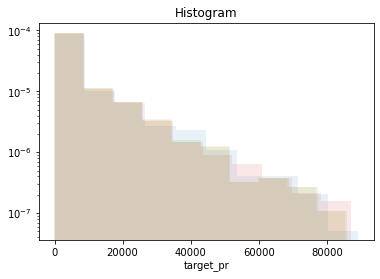

In [22]:
sf = 27
compare_preds([data[arch][sf]["predictions"] for arch in data.keys()], [data[arch][sf]["bias"] for arch in data.keys()], test_sets[sf], list(data.keys()))

## Comparing U-Nets with different coarsening scale factors

Plotted below are the U-Net predictions for the 5 different scale factors and beneath them the corresponding coarsened input and below that the residuals. The first column is the target precipitation of the full-resolution CPM output.

There are three rows for 10 randomly selected timestamps from the test set.

In [23]:
rng = np.random.default_rng(seed=42)
timestamps = rng.choice(test_sets[2].time, 10)
timestamps = np.append(timestamps, test_sets[2].time[0])

unet_datasets = [test_sets[2].target_pr]+[data["u-net"][sf]["predictions"]['pr'] for sf in scale_factors]
input_datasets = [test_sets[2].target_pr]+[test_sets[sf]['pr'] for sf in scale_factors]
residual_datasets = [test_sets[2].target_pr - test_sets[2].target_pr] + [test_sets[sf].target_pr - data["u-net"][sf]["predictions"]['pr'] for sf in scale_factors]

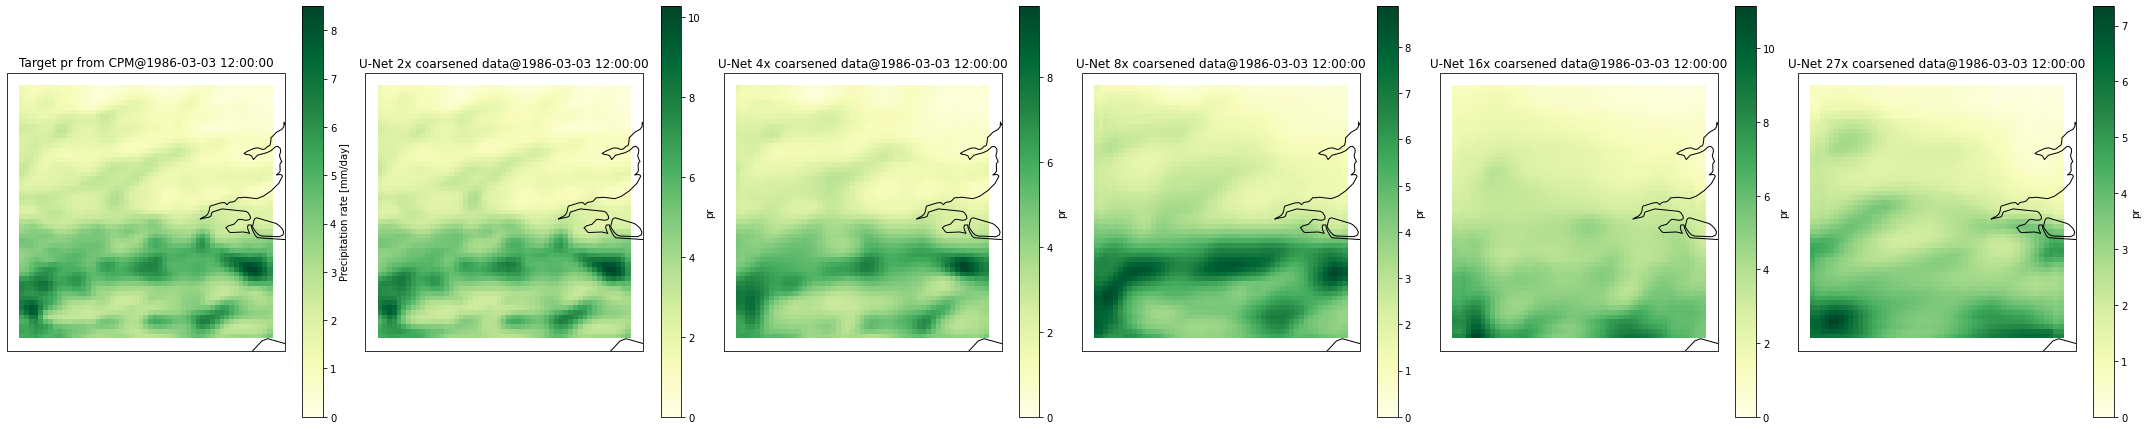

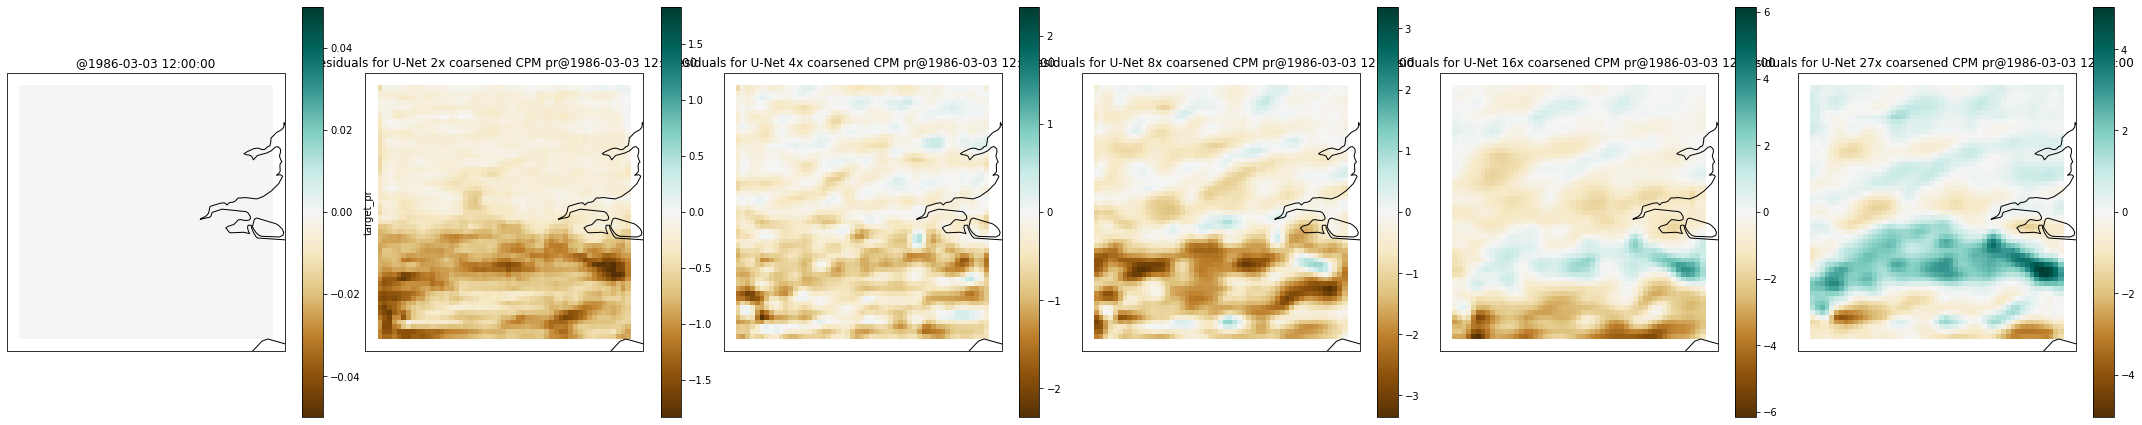

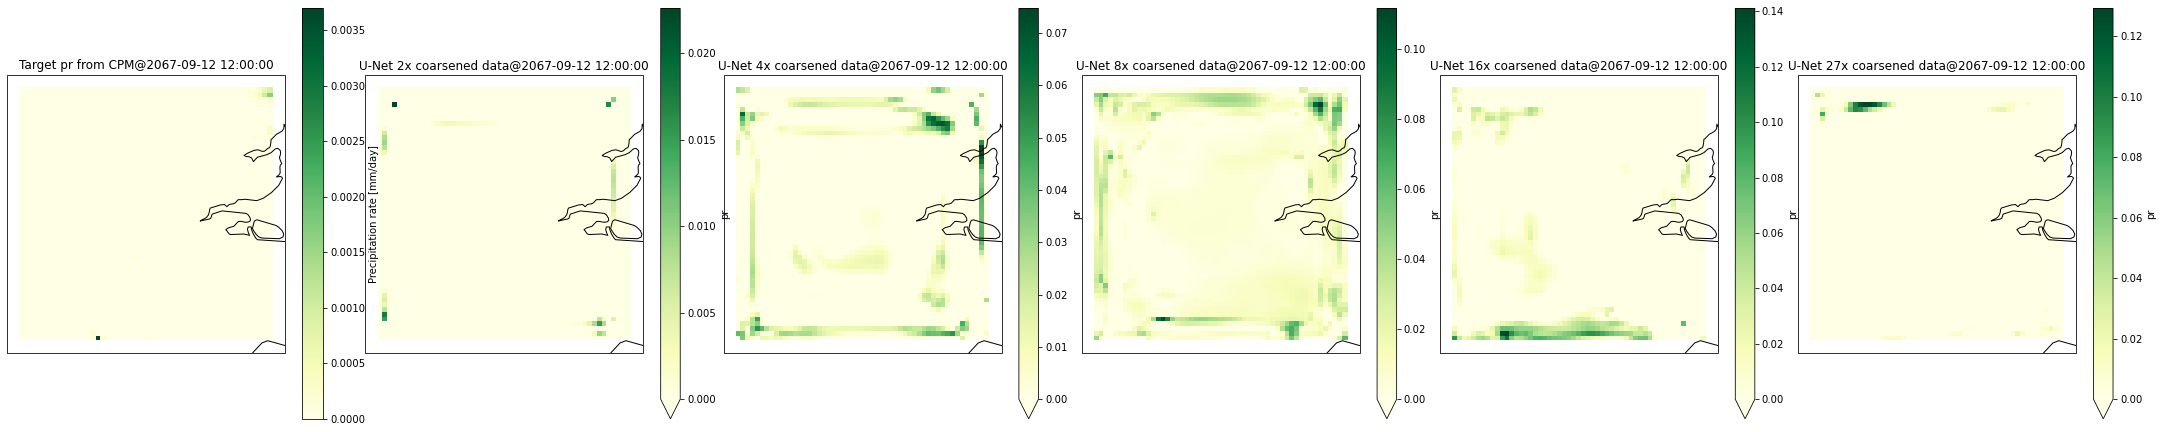

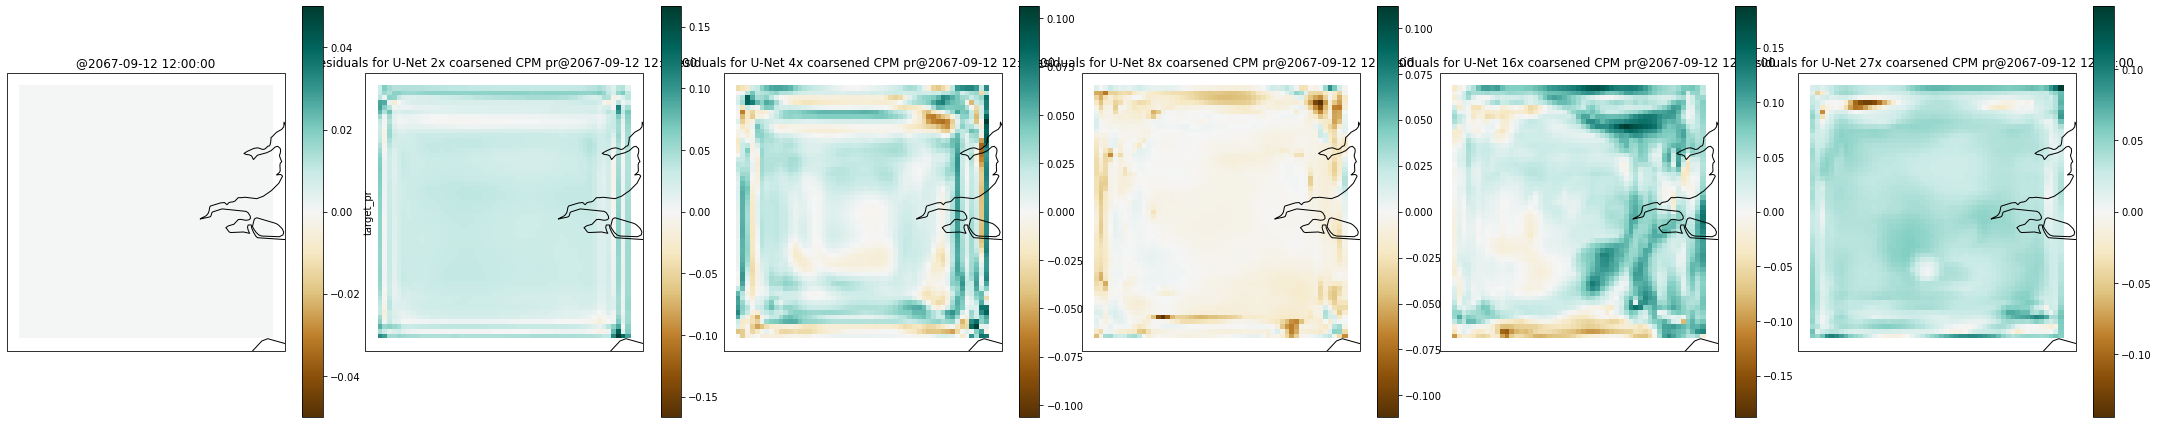

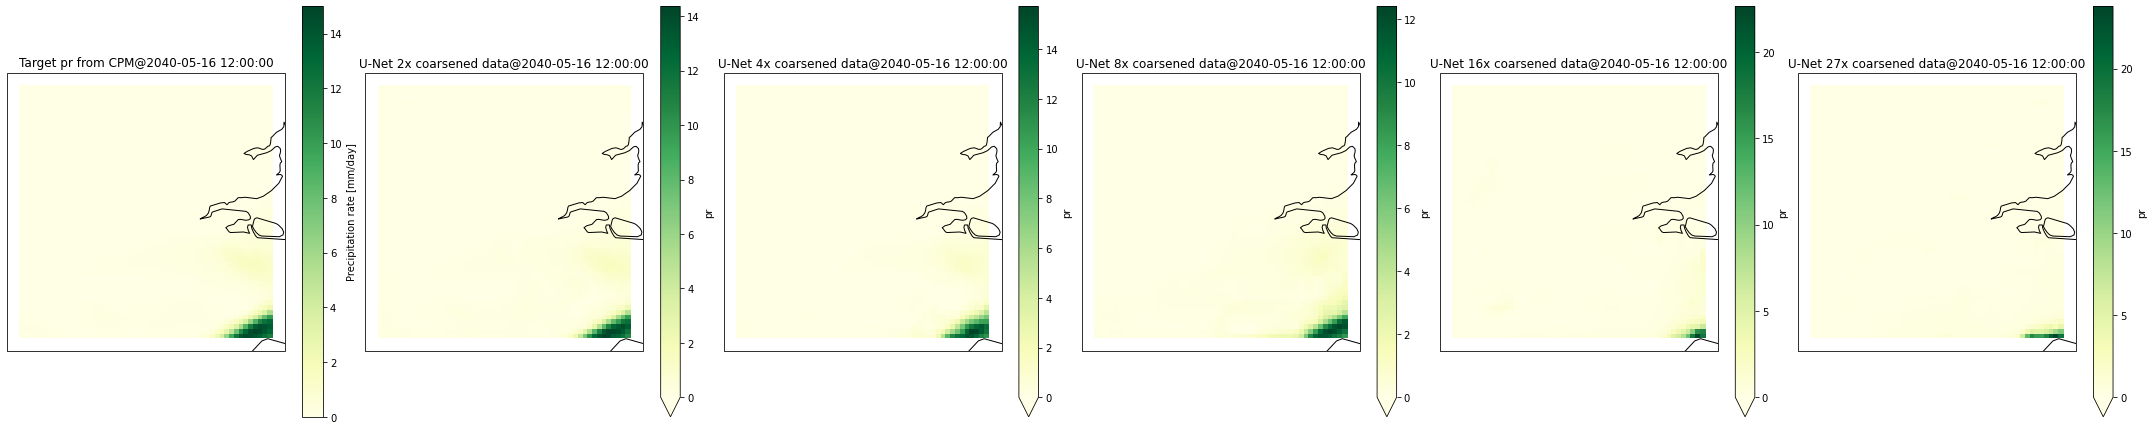

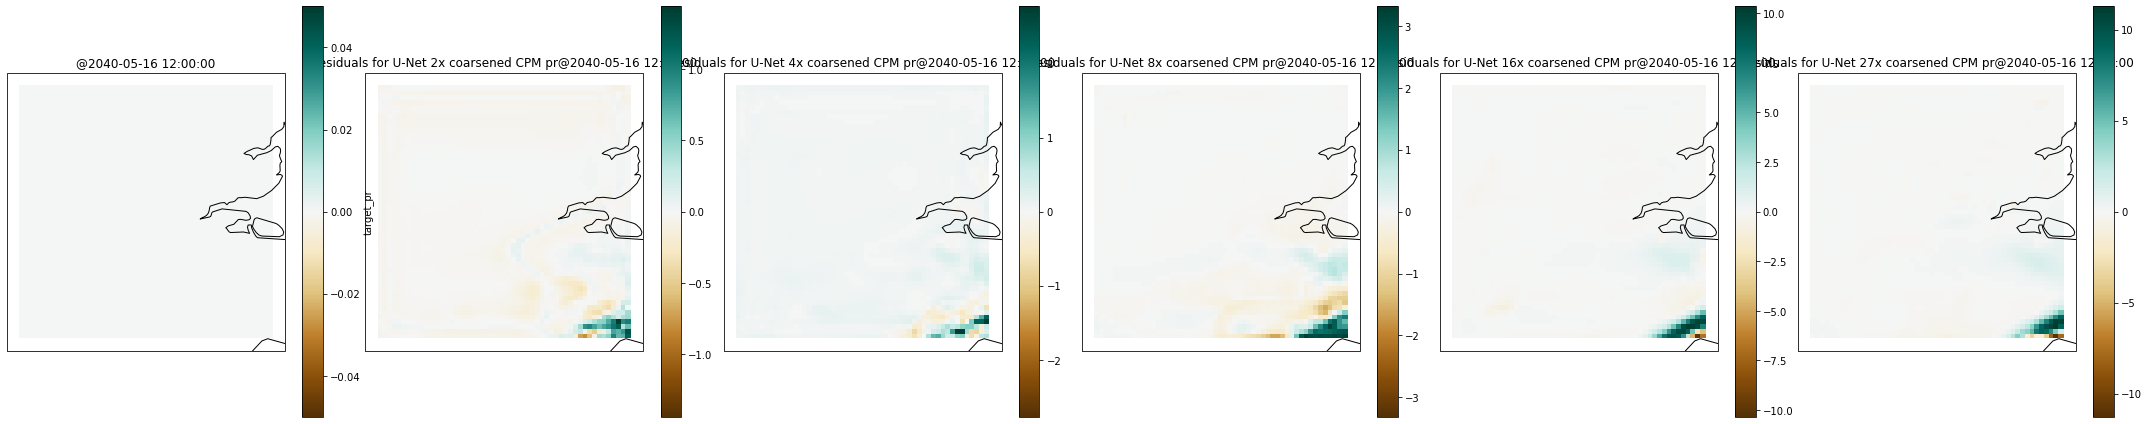

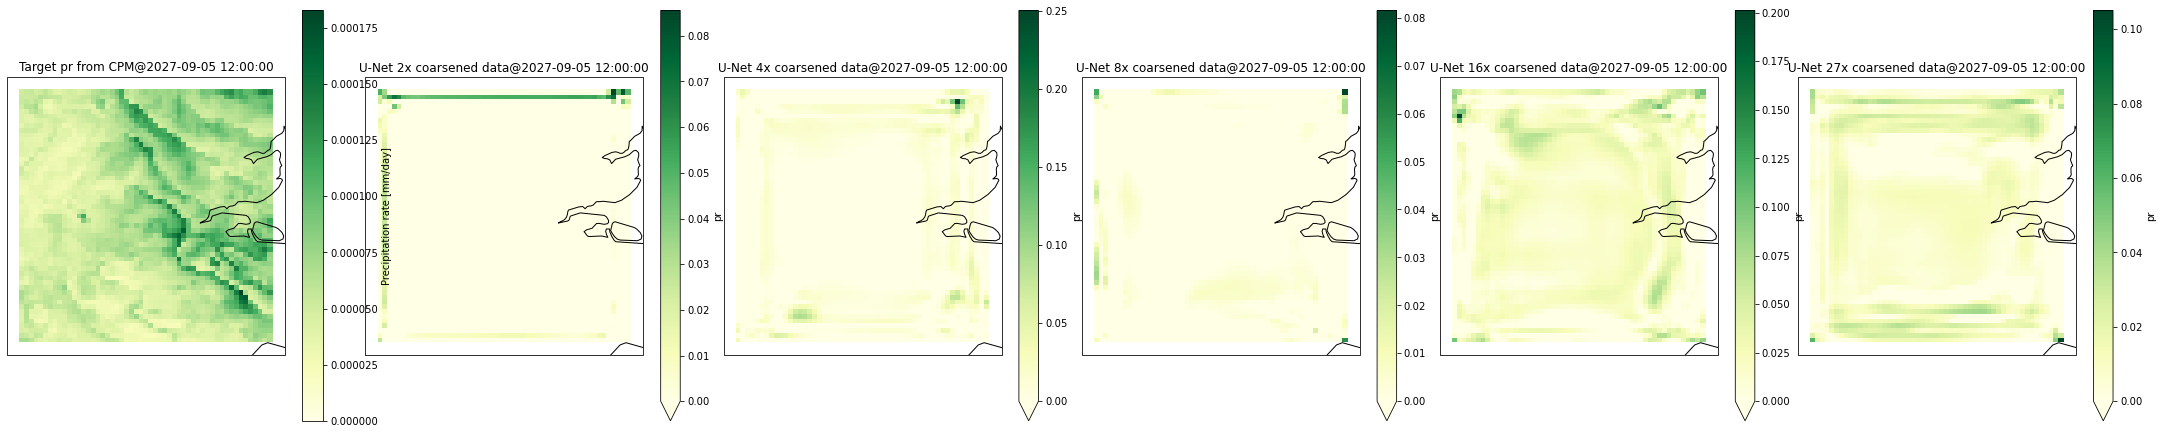

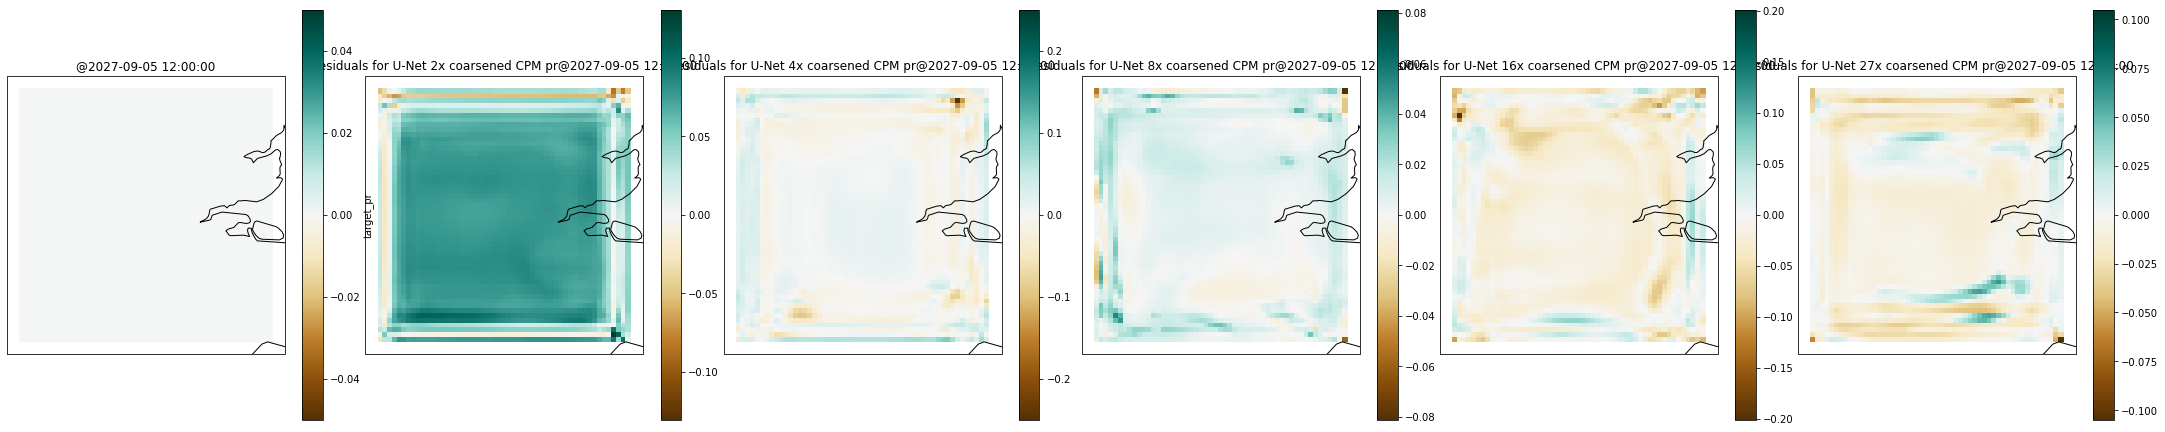

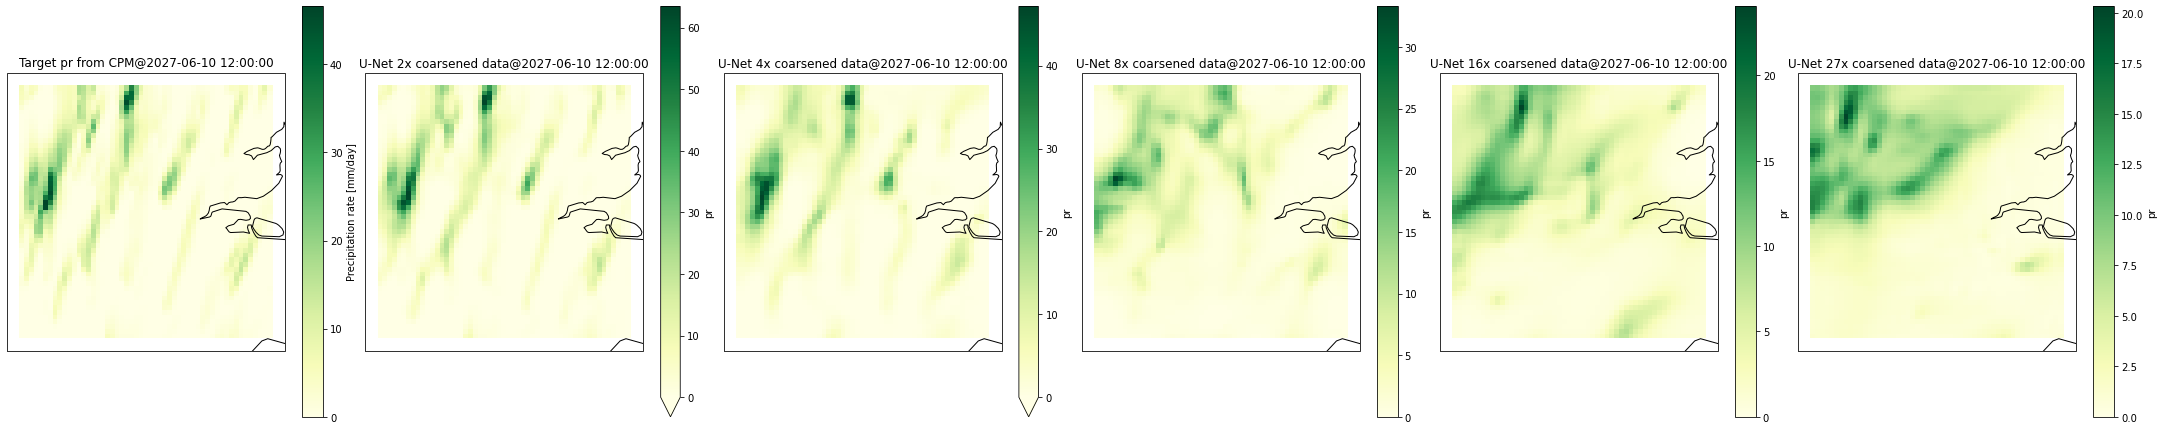

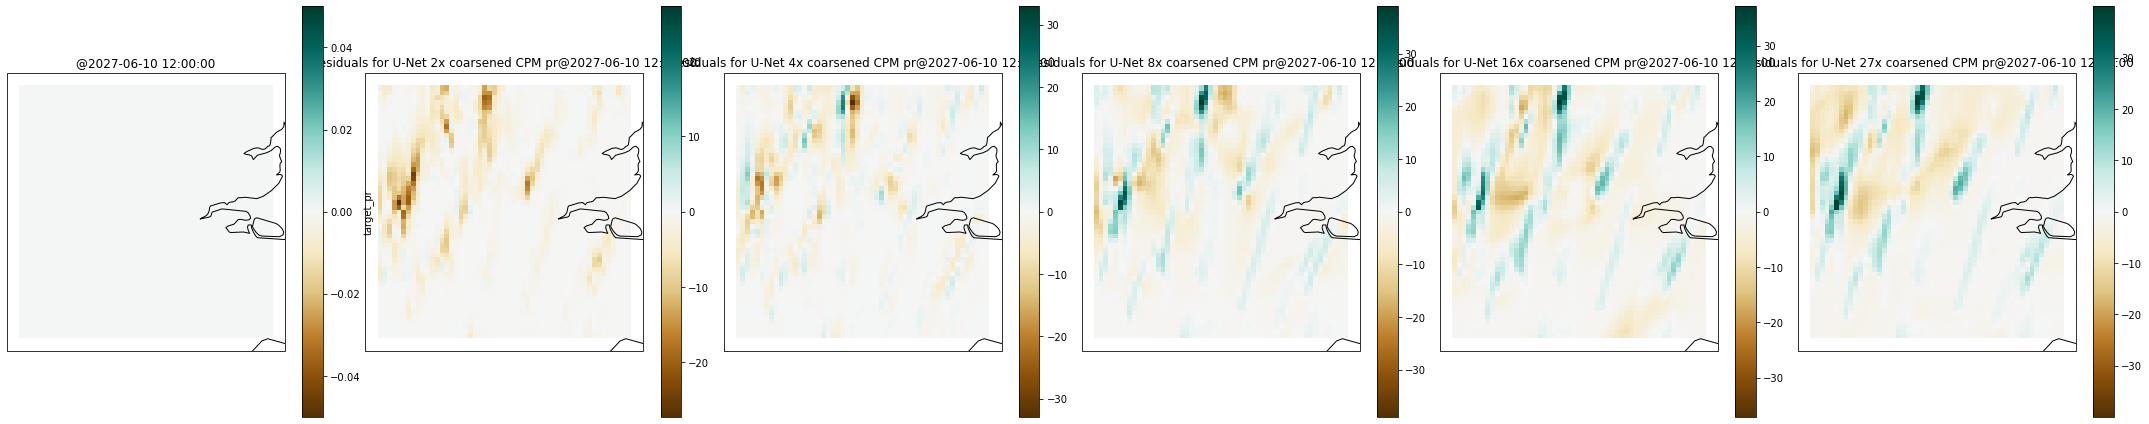

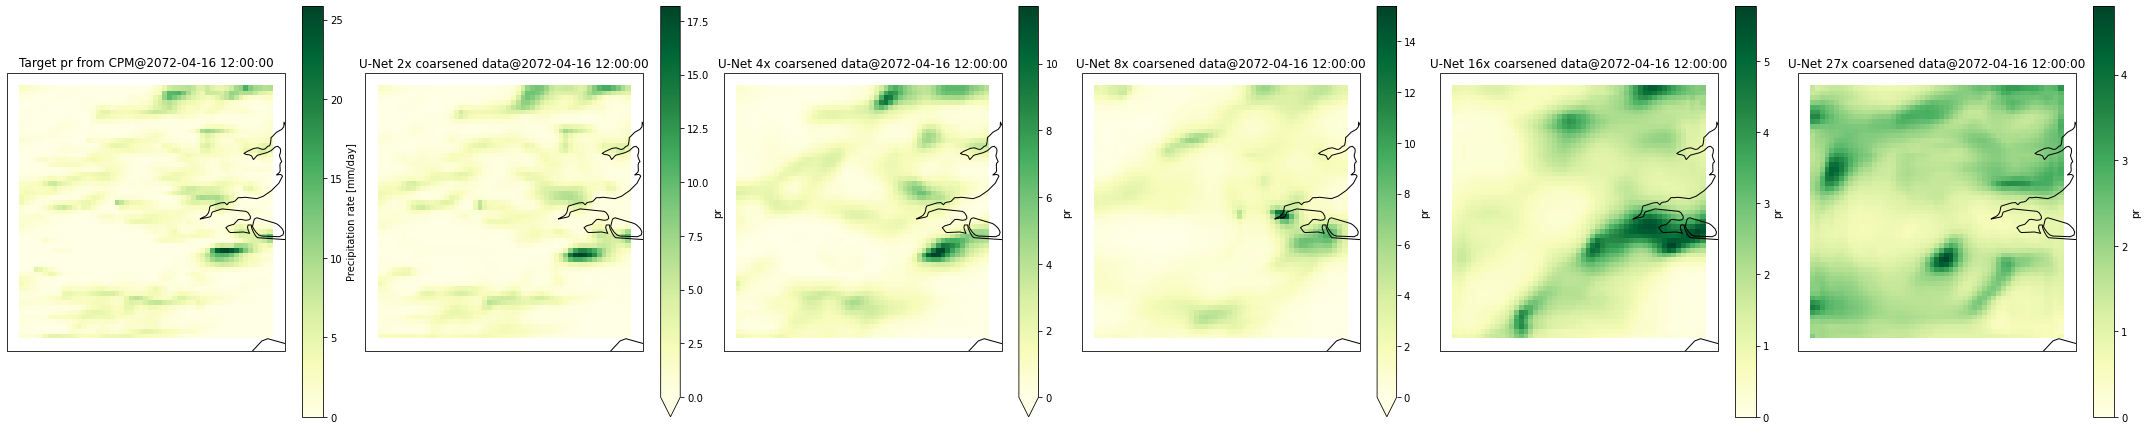

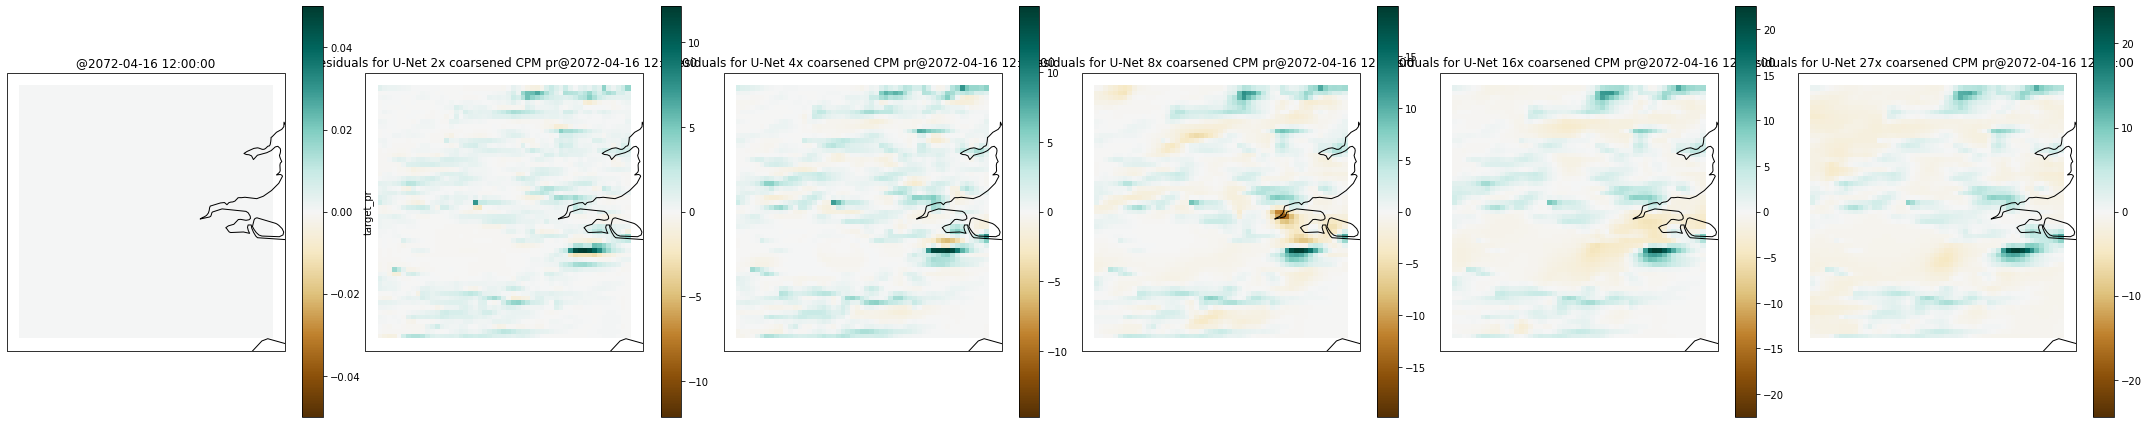

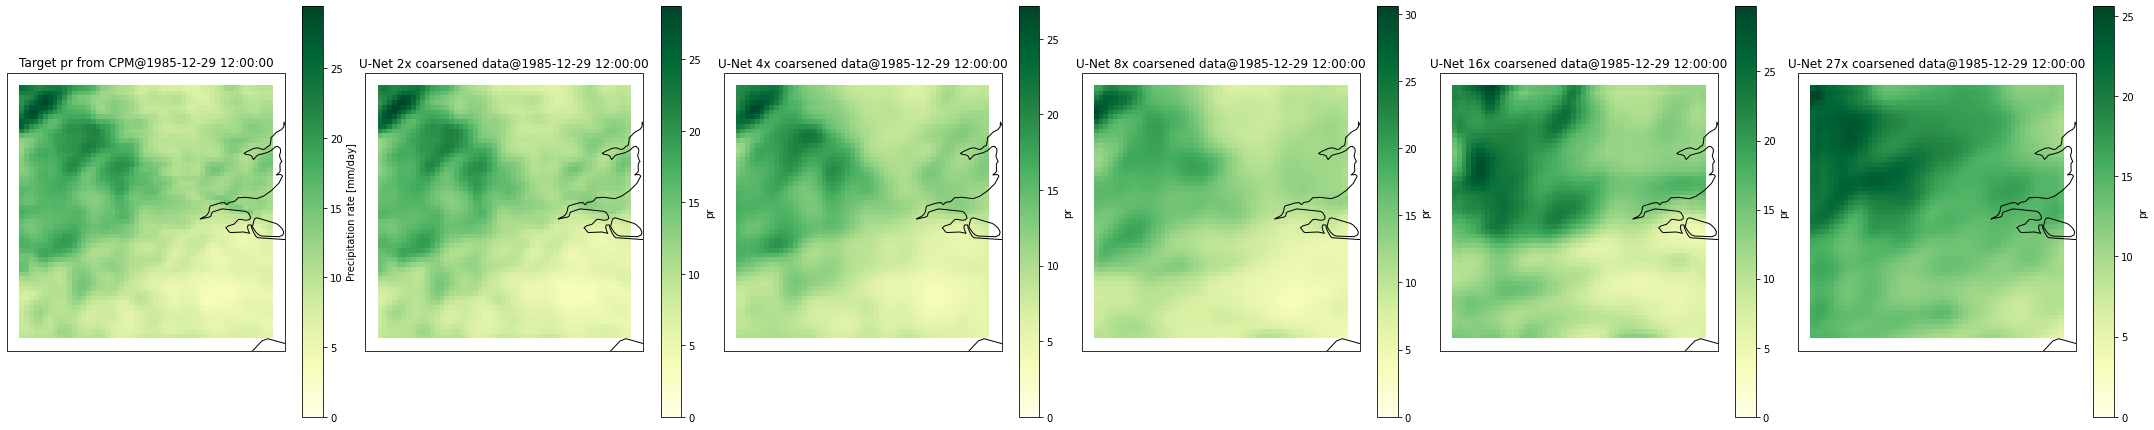

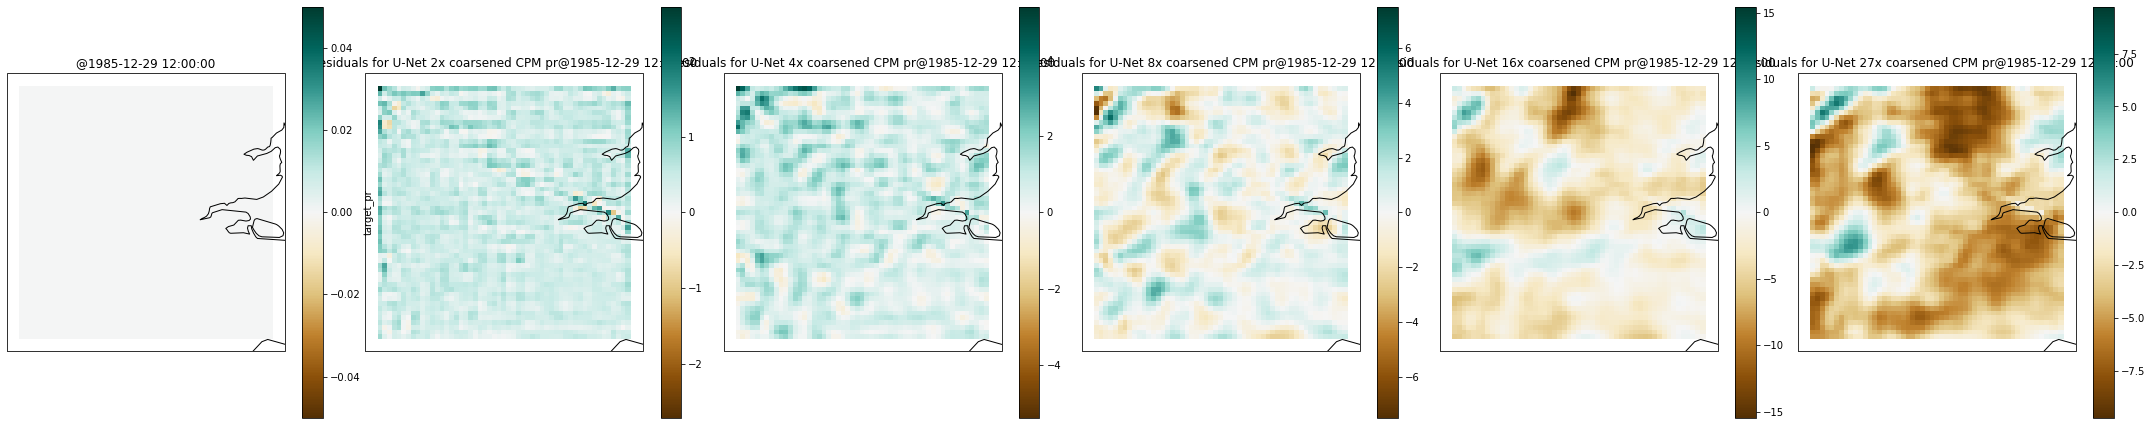

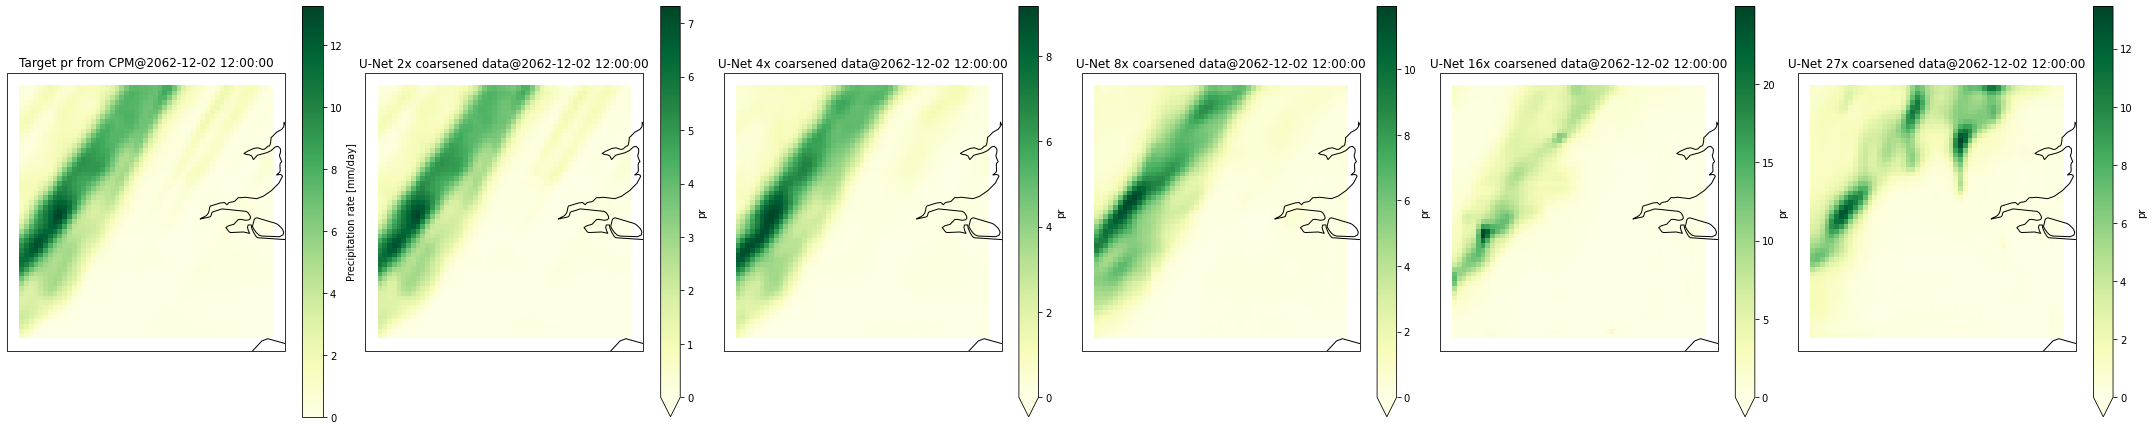

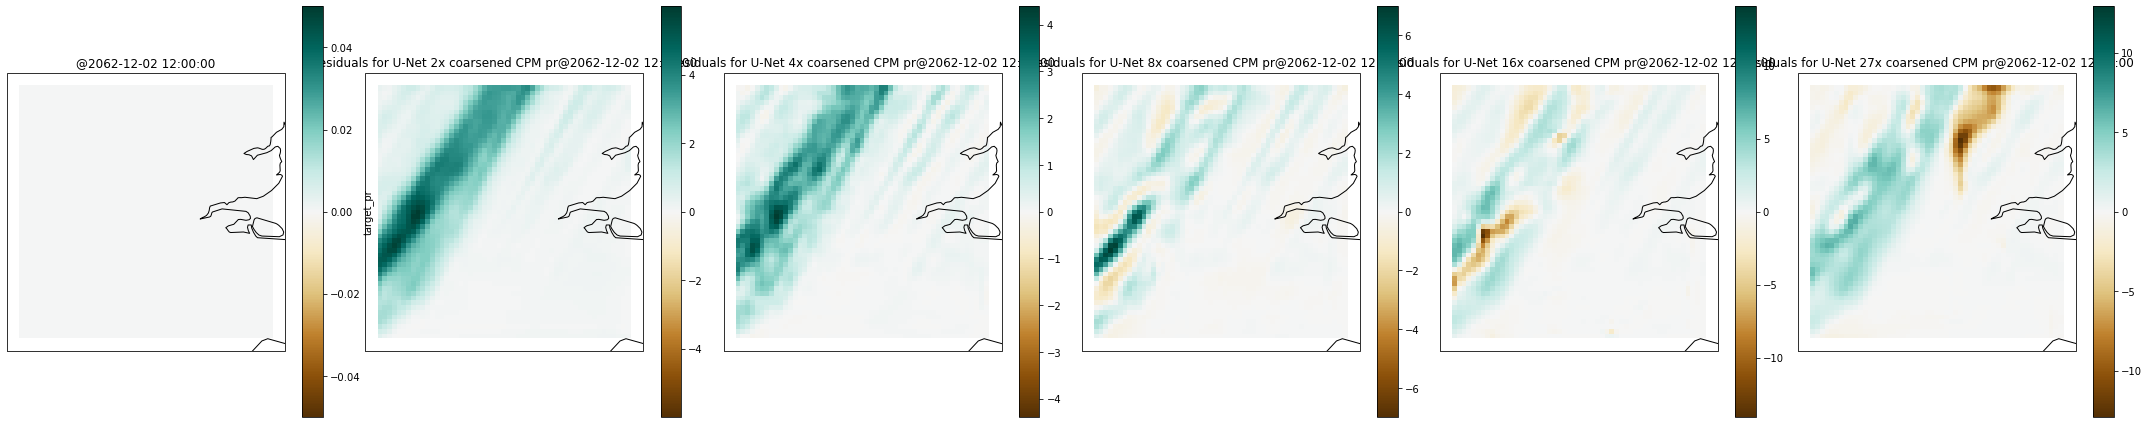

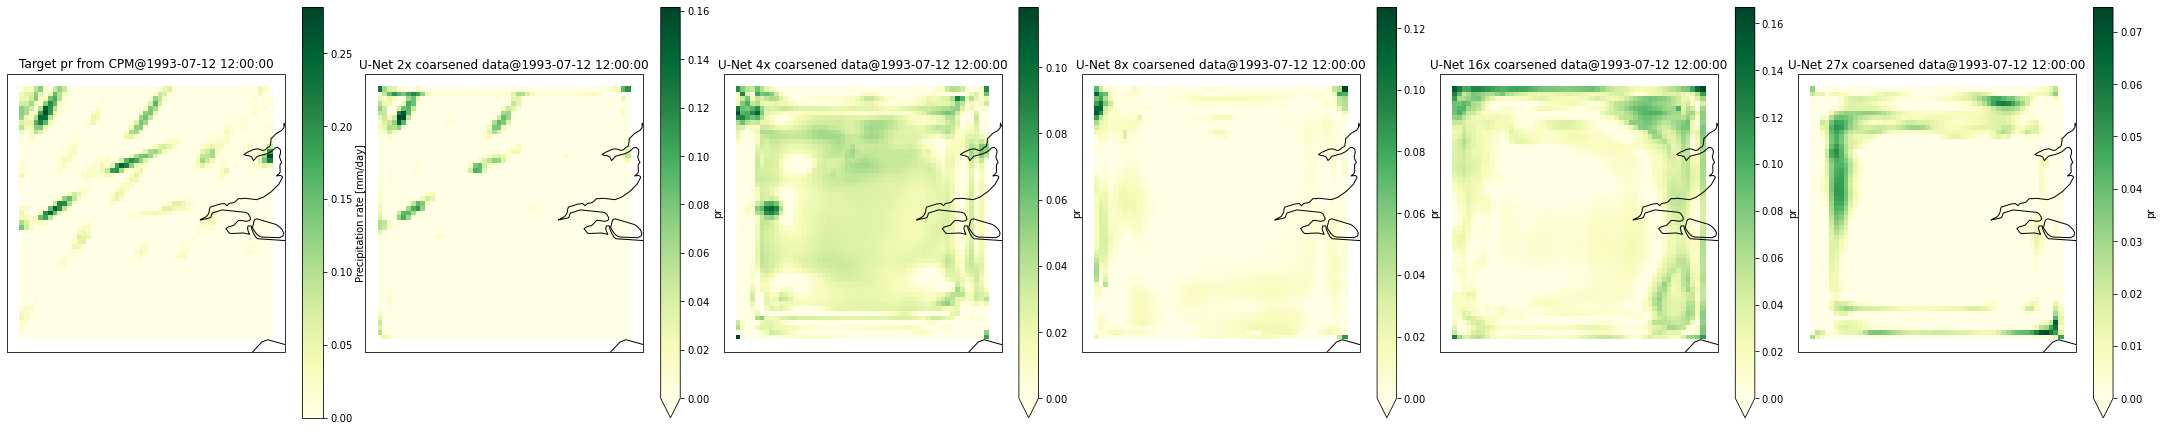

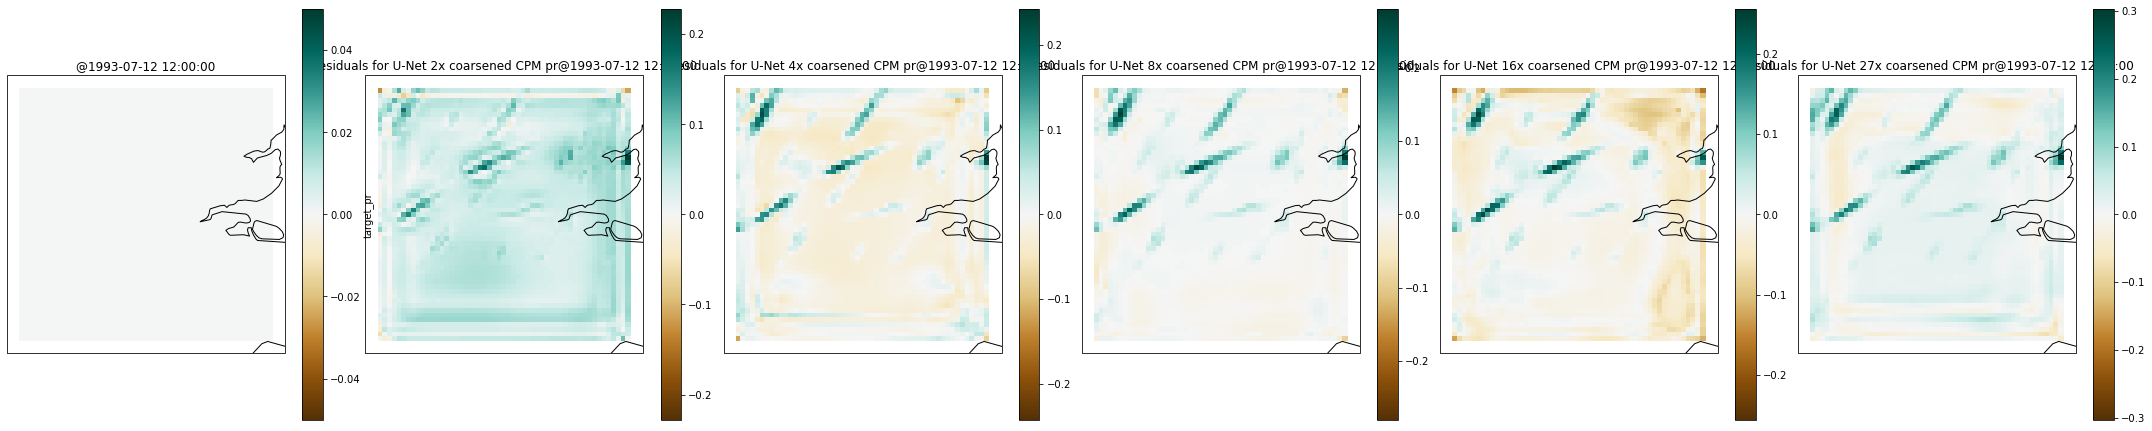

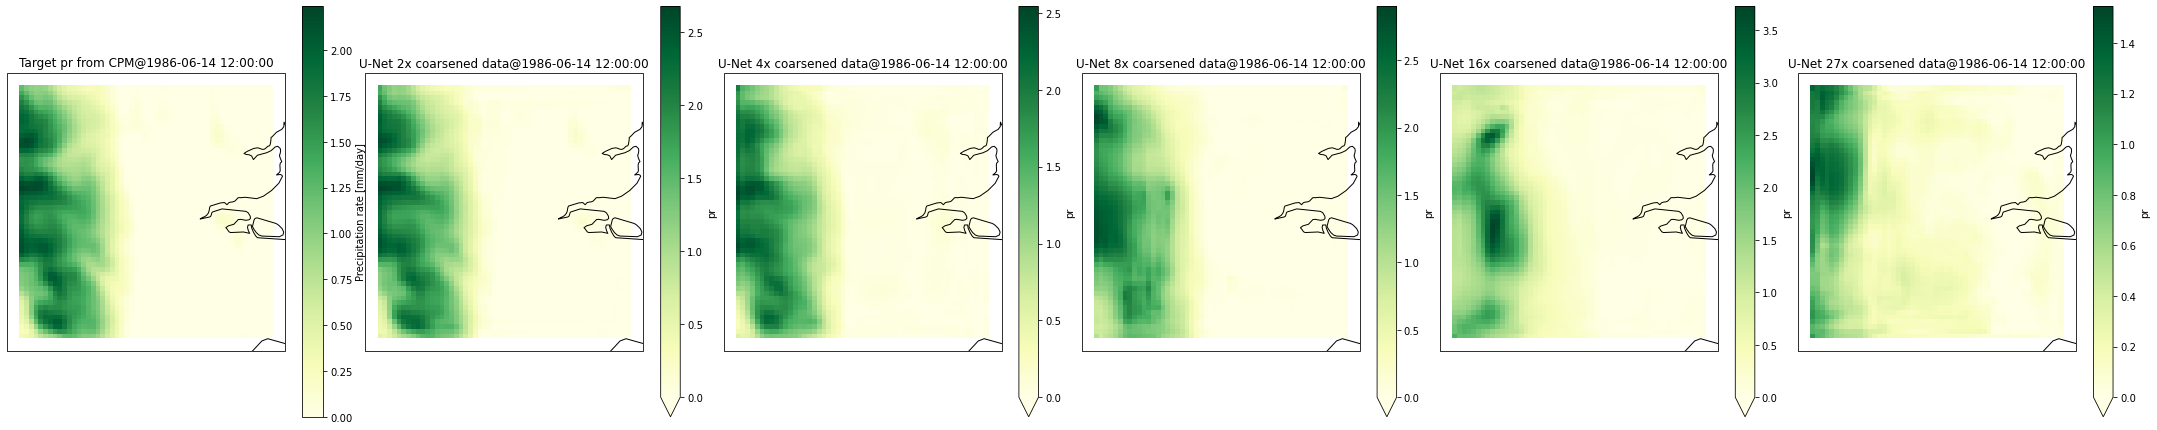

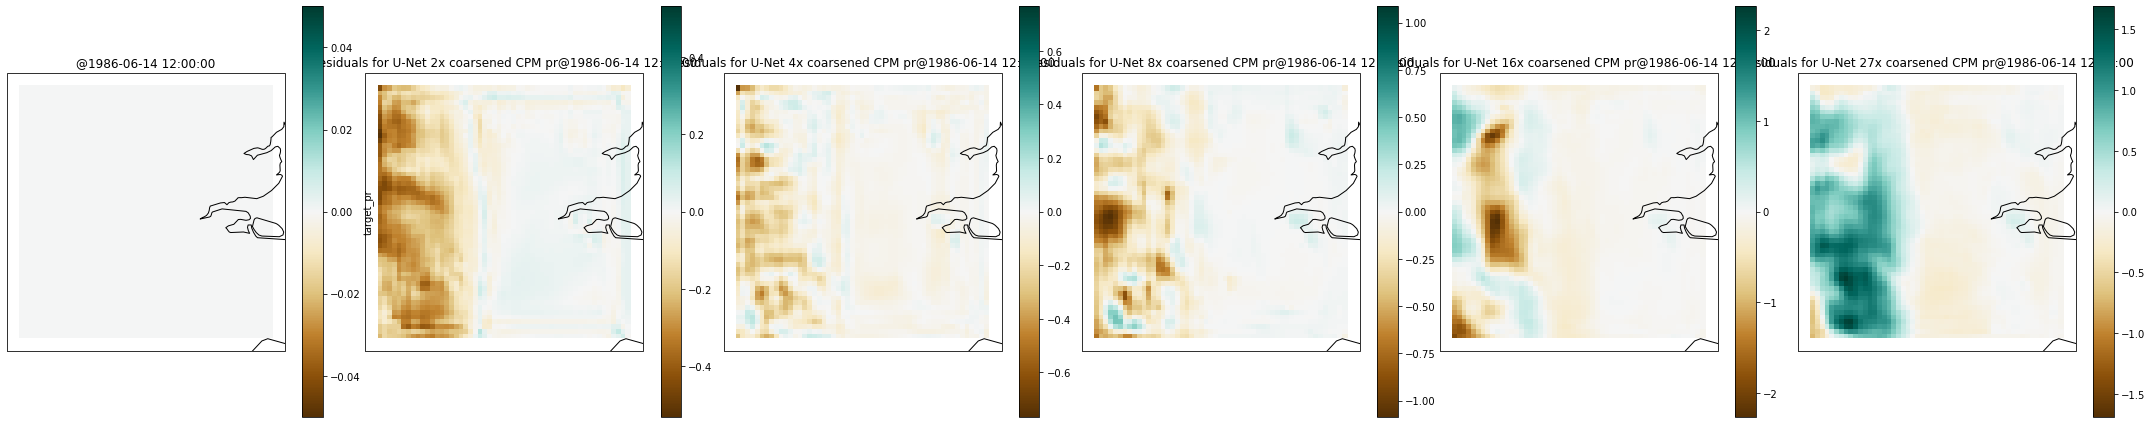

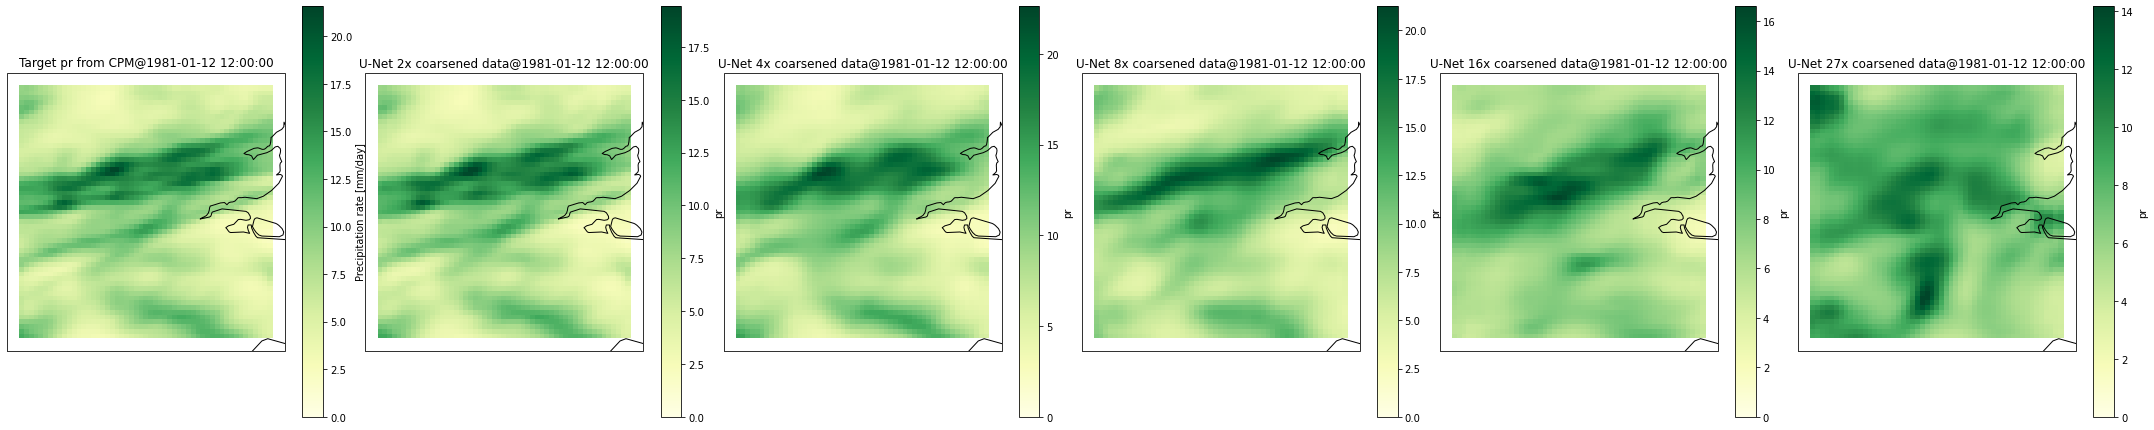

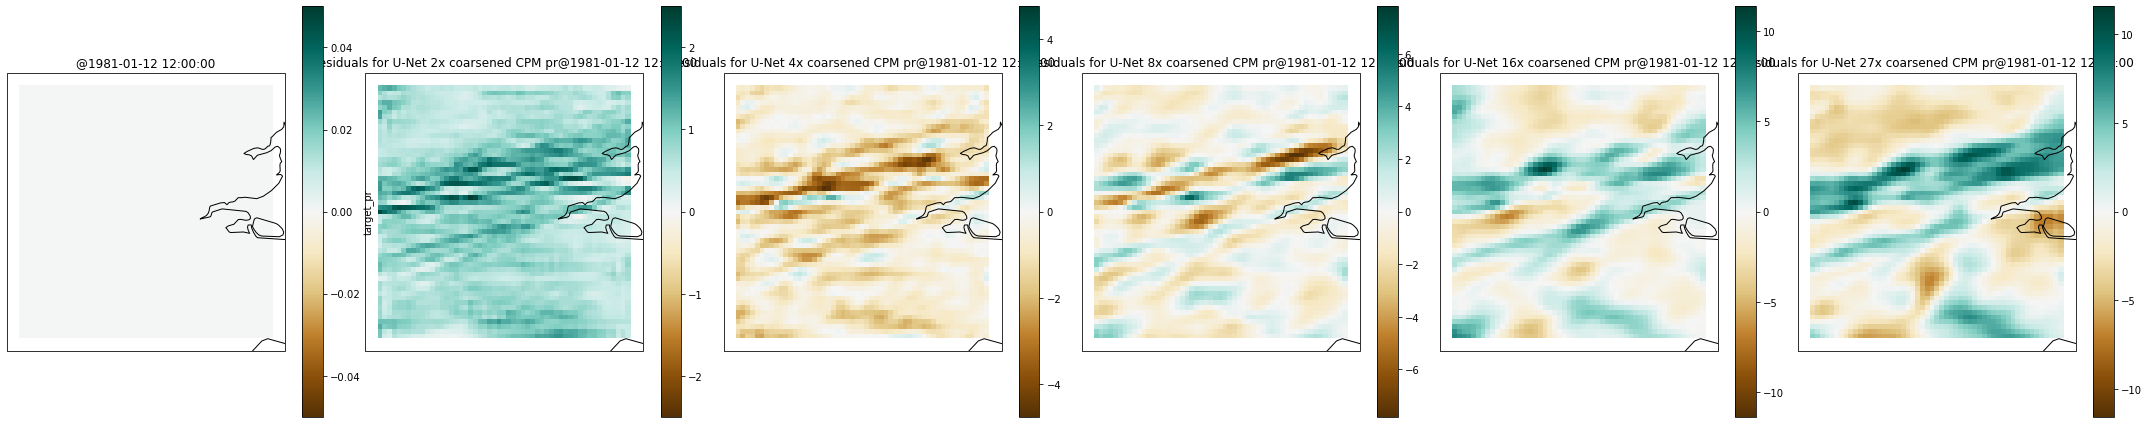

In [24]:
vmax = None#45 # max(*[ds.max().values for ds in unet_datasets+input_datasets])
import matplotlib.pyplot as plt
for timestamp in timestamps:
    plots_at_ts(unet_datasets, timestamp, titles=["Target pr from CPM"]+[f"U-Net {sf}x coarsened data" for sf in scale_factors], vmax=vmax)
#     plots_at_ts(input_datasets, timestamp, titles=["Target pr from CPM"]+[f"{sf}x coarsened CPM pr" for sf in scale_factors], vmax=vmax, cmap='Greens')
    plots_at_ts(residual_datasets, timestamp, titles= [""]+[f"Residuals for U-Net {sf}x coarsened CPM pr" for sf in scale_factors], vmin=None, cmap="BrBG")
    plt.show()